Regression for predicting the price of the house

# Steps we will follow:

## 1. Define the objective
- defining the target 
- defining a acceptable error (we will take into account MAE for the error) → **So define Maximum MAE**

---

## 2. Select data for the model
- cleaning of that data (en principio no va a hacer falta)
- Detectar outliers que puedan romper el modelo

---

## 3. EDA para detectar si un linear regression va a ser suficiente: justificarlo y aplicar un linear regression para demostrarlo

### 3.1 Univariado
- Distribución del target.
- Distribución y estadísticas de las features.

### 3.2 Bivariado
- Correlaciones numéricas (heatmap).
- ANOVA / boxplots para categóricas vs target.

### 3.3 Detectar no linealidades
- Scatterplots X vs Y.
- Transformaciones (log, sqrt) si una relación no es lineal.
- Crear polinómicas si es necesario.

> 👉 Aquí decides si la regresión lineal tiene sentido o necesitas algo más poderoso.

---

### ✔️ ¿Cómo elegir definitivamente?
Se hace así:

1️⃣ Divide los datos (train/test)  
2️⃣ Ejecuta cross-validation con GridSearch:  

- Lasso  
- Ridge  
- ElasticNet  

El que dé mejor MAE o RMSE → ese gana.  

➡️ No se decide a ojo. Se decide con CV.

---

## 4. Validar Supuestos: (aplicar lasso directamente y verificar)
- Linealidad
- Independencia de residuos

---

## 5. Preprocesing
- Dividir train y test
- Scaled, categorical-variables...

---

## 6. Entrenar y probar con varios modelos (usando cross validation)

### Entrenar y probar con:
- ✔️ RANSAC  
  Para outliers, recomendado

- ✔️ Theil-Sen  
  Robusto a ruido, muy usado en datos inestables

- ✔️ HuberRegressor  
  Mezcla LR con robustez

- ✔️SVM Regressor
-Relaciones no lineales con kernels

- ✔️ RandomForestRegressor  
  No lineal, buen baseline potente

- ✔️ CatBoost  
  De lo mejor en tabular  
  No requiere escalado  
  Maneja categóricas

- ✔️ XGBoost

- ✔️ LightGBM  

Casi siempre da un rendimiento brutal

---

### Evaluar métricas
- R², MAE
- Comprobar si hay overfitting o underfitting en cada modelo:  
    - Overfitting → test mucho peor que train  
    - Underfitting → ambos malos  
    - Buen modelo → train ≈ test y métricas buenas  

> 👉 El test manda; si test es bueno → el modelo generaliza.

---

## 7. Diagnóstico final (para verificar si el modelo que hemos elegido esta bien)
- Residuals vs predicted
- Predicted vs actual
- Q-Q plot
- Importancia de variables
- Coeficientes interpretables (si es lineal)














### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import statistics as st

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

import optuna
from sklearn.linear_model import Lasso, Ridge, ElasticNet


from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import xgboost as xgb
import lightgbm as lgb



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



### LOAD DATA

In [2]:
#load the data

data = pd.read_csv('../data/cleaned/data_final.csv')
dataCpy = data.copy()

### 1: Define the objective of the regression: 
- Objective: our regression model will predict ("tell") the announcement price of your house with the house data as input. 
- Target feature: price
- We will use R2 (for evaluating generalization capacity of the model) and MAE (for evaluating precision of the model)


But.... what would be an acceptable maximum MAE?

In [3]:
#Since the target feature is the price, the MAE will be in € units.

#AN OPTION WOULD BE: 

#1.We will get which is the standard deviation of "price" feature 
std_price = dataCpy["price"].std()
print(f"Standard deviation of the feature 'price': {round(std_price,2)}€") #--> The values of "price" differ from the mean: 310649.51€

#2.The maximum accepatble MAE could be a percentage of that standard deviation value. 
#In the house business, 31.000€ more or less expensive may have an impact on buyers, however a price of 10.000€ may not have so much impact. 
#So an acceptale MAE will be 10.000€ for all the predictions. 





Standard deviation of the feature 'price': 310775.75€


HOWEVER: 

The first option would be easier to implement (1 fixed maximum MAE for all the predictions). However, this would not be true. 
Since 10.000€ may not have an impact (would be an acecptable MAE) for a house of 500.000€ for example, but would have a big 
impact (would NOT be an acceptable MAE) for a house of 50.000€.

So we instead of MAE, will take into account the "relative MAE" with a maximum acceptable error of 10%. So for example: 

In [82]:

print(f"Cheapest House: {round(min(dataCpy["price"]),2)}€")
print(f"10% = {round(min(dataCpy["price"])*0.1,2)}€\n")

print(f"Most Expensive House: {round(max(dataCpy["price"]),2)}€")
print(f"10% = {round(max(dataCpy["price"])*0.1,2)}€\n")

print(f"Average price House: {round(st.mean(dataCpy["price"]),2)}€")
print(f"10% = {round(st.mean(dataCpy["price"])*0.1,2)}€\n")


Cheapest House: 50000.0€
10% = 5000.0€

Most Expensive House: 2500000.0€
10% = 250000.0€

Average price House: 476983.85€
10% = 47698.38€



### 2: Data cleaning for the model

In [5]:
#1.We will check if there are any outliers in the values of "price"

#1.1 First we will see if there are univariate outliers in the feature price
Q1 = dataCpy['price'].quantile(0.25)
Q3 = dataCpy['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = dataCpy[(dataCpy['price'] < Q1 - 1.5*IQR) | (dataCpy['price'] > Q3 + 1.5*IQR)]

print(f"Univariate Outliers: {outliers.head()}") #Here we get some houses with a very expensive price, however they are not really outliers (nor strange values), they are just expensive houses which we must also take into account.

#1.2 Second we will see if there are multivariate outliers

iso = IsolationForest(contamination=0.01, random_state=42)
numerical_features = dataCpy.select_dtypes(include=np.number)
outliers_IF = iso.fit_predict(numerical_features)

# Filtrar solo los outliers
outliers_IF_df = dataCpy[outliers_IF == -1]

print("Isolation Forest - solo outliers:")
print(outliers_IF_df)


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
outliers_LOF = lof.fit_predict(numerical_features)

# Filtrar solo los outliers
outliers_LOF_df = dataCpy[outliers_LOF == -1]

print("LOF - solo outliers:")
print(outliers_LOF_df)

#As we can see these are not outliers (there are not strange values), they are just expensive or houses with different features. We will maintain them.



Univariate Outliers:                                                url      price      zone  \
78   https://www.idealista.com/inmueble/108492917/  1400000.0    deusto   
114  https://www.idealista.com/inmueble/105222282/  2500000.0  uribarri   
137  https://www.idealista.com/inmueble/108035998/  1180000.0  uribarri   
148  https://www.idealista.com/inmueble/108037499/  1190000.0  uribarri   
185   https://www.idealista.com/inmueble/32760790/  1400000.0  uribarri   

                        neighborhood  built_area  usable_area  bedrooms  \
78                 Arangoiti, Bilbao       351.0        350.0         4   
114  Campo Volantin-Castaños, Bilbao       426.0        384.0         8   
137  Campo Volantin-Castaños, Bilbao       114.0         95.0         3   
148  Campo Volantin-Castaños, Bilbao       250.0        230.0         4   
185                 Uribarri, Bilbao       426.0        350.0         8   

     bathrooms  floor  exterior  ...  garage  storage_room  balcony    new  \

### 3.EDA 
- To evaluate if a linear regression model can accurately capture the relationship between the features and the target, before training any model.

UNIVARIATE------------------------------------
Target - Estadísticas generales:
count    1.229000e+03
mean     4.769944e+05
std      3.107758e+05
min      5.000000e+04
25%      2.650000e+05
50%      3.950000e+05
75%      5.990000e+05
max      2.500000e+06
Name: price, dtype: float64

Skew: 2.109654537879016
Kurtosis: 6.894991473049991


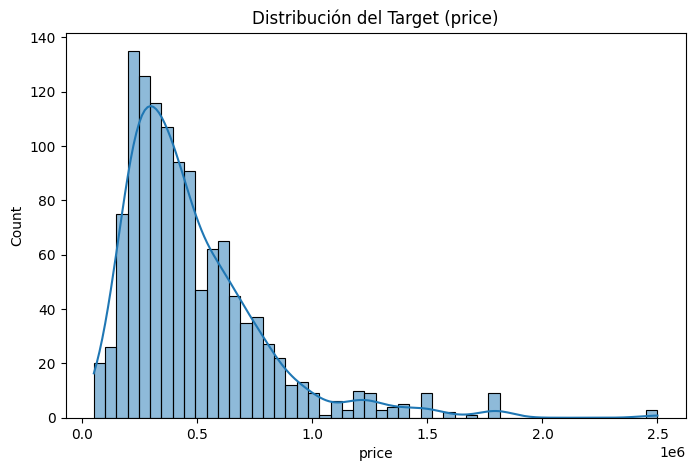


Feature: built_area
count    1229.000000
mean      114.688365
std        66.047508
min        30.000000
25%        72.000000
50%        98.000000
75%       134.000000
max       760.000000
Name: built_area, dtype: float64


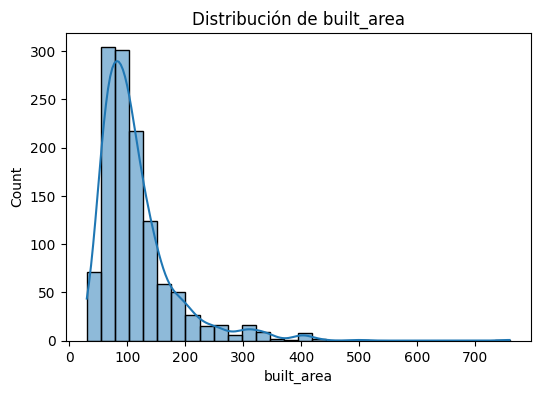


Feature: usable_area
count    1229.000000
mean      102.855134
std        60.286864
min        26.336611
25%        65.000000
50%        85.000000
75%       120.000000
max       706.012840
Name: usable_area, dtype: float64


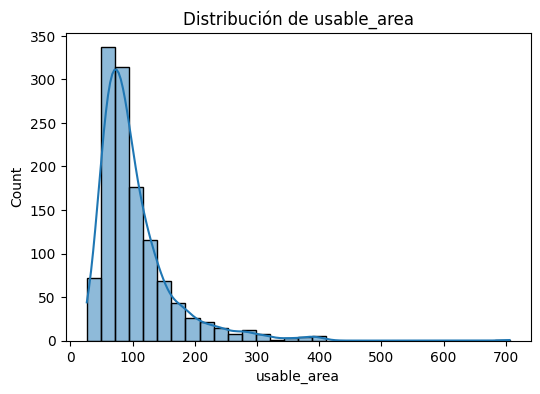


Feature: bedrooms
count    1229.000000
mean        3.068348
std         1.434867
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: bedrooms, dtype: float64


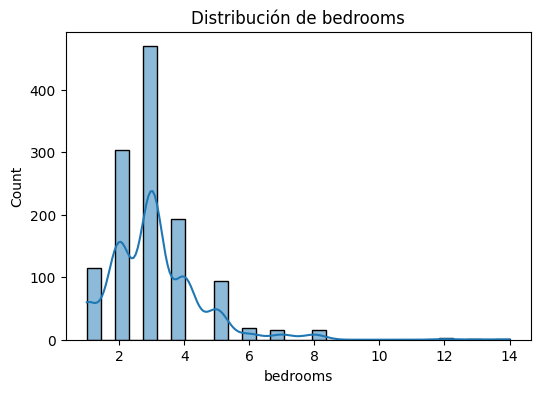


Feature: bathrooms
count    1229.000000
mean        1.768104
std         0.785096
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: bathrooms, dtype: float64


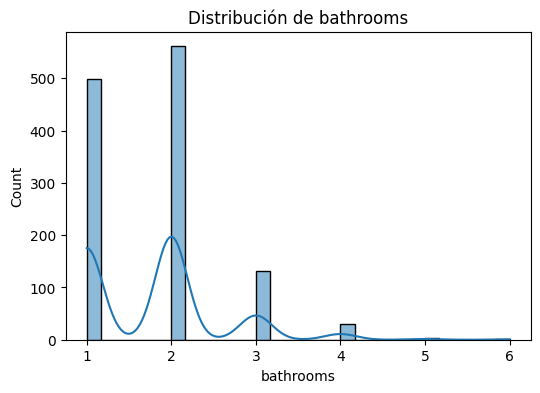


Feature: floor
count    1229.000000
mean        3.696908
std         3.102530
min        -1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        35.000000
Name: floor, dtype: float64


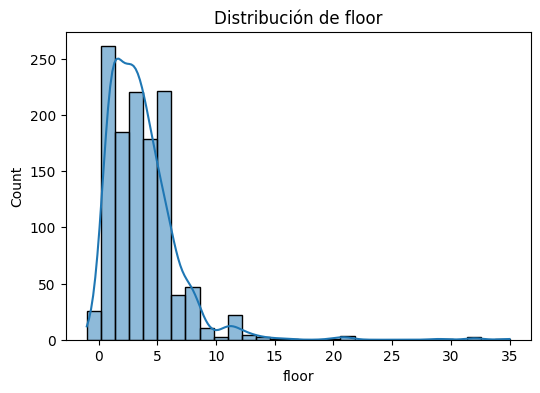


Feature: year
count    1229.000000
mean     1961.676159
std        37.060905
min      1800.000000
25%      1941.000000
50%      1963.000000
75%      1980.000000
max      2025.000000
Name: year, dtype: float64


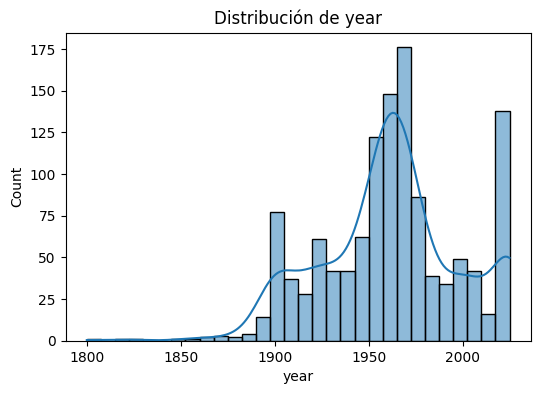

BIVARIATE------------------------------------


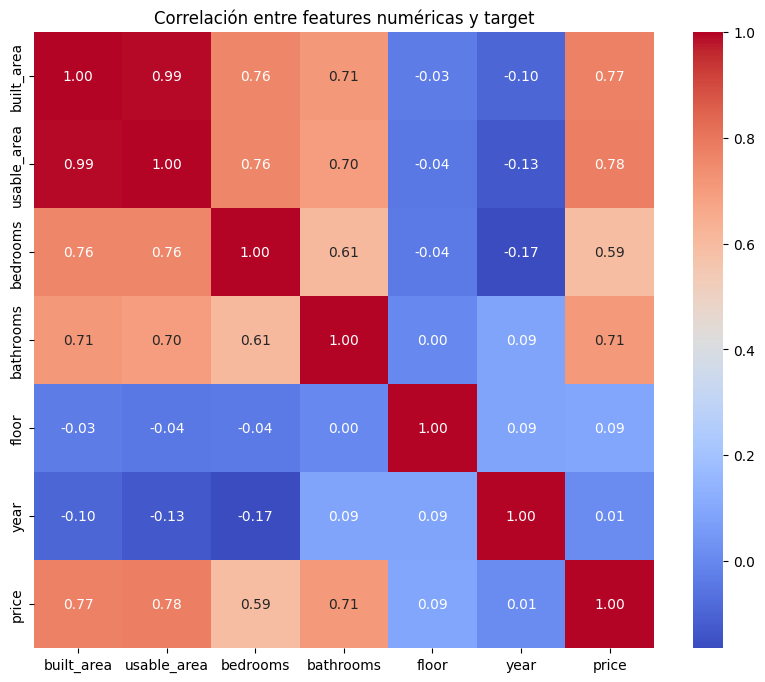

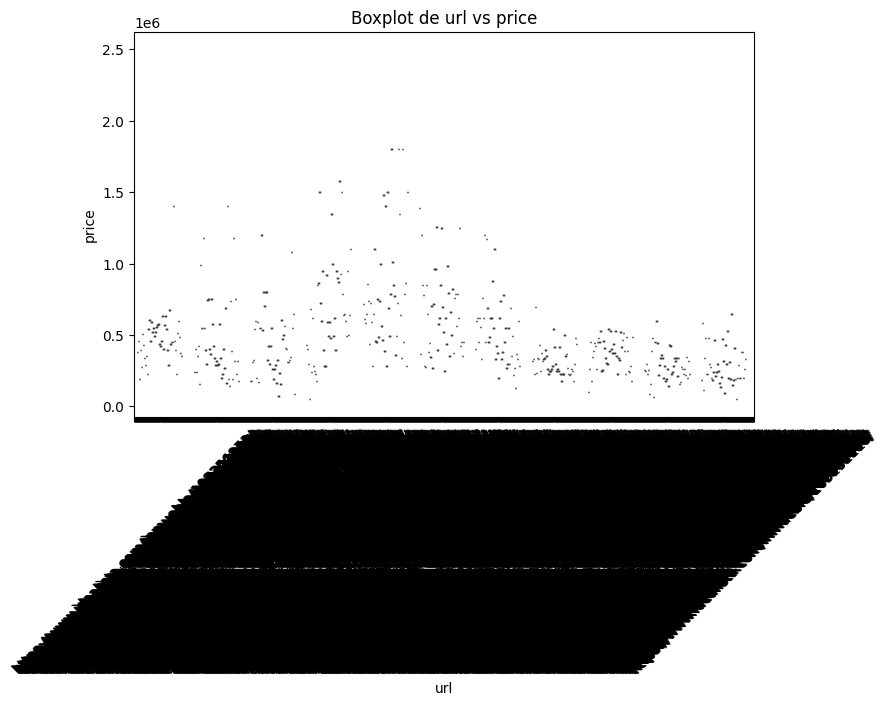

C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\david.r\AppData\Local\Temp\ipykernel_4196\2535576384.py:66: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_val, p_val = stats.f_oneway(*groups)


ANOVA url vs price: F=nan, p=nan


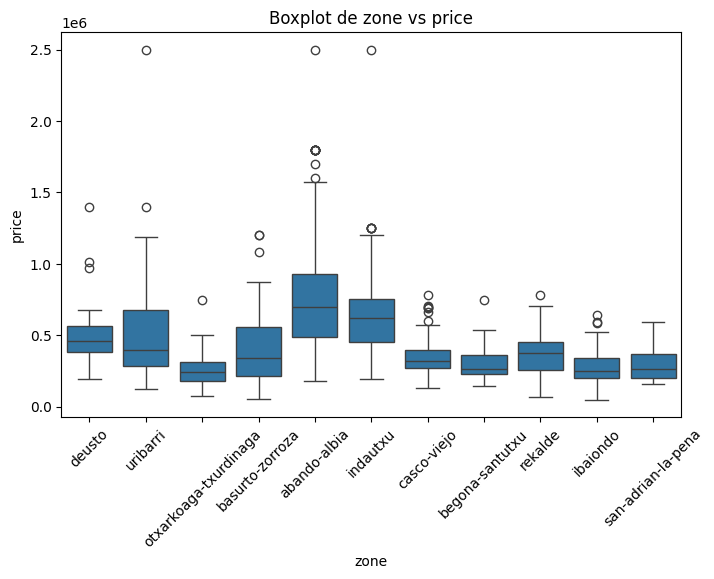

ANOVA zone vs price: F=62.03, p=0.0000


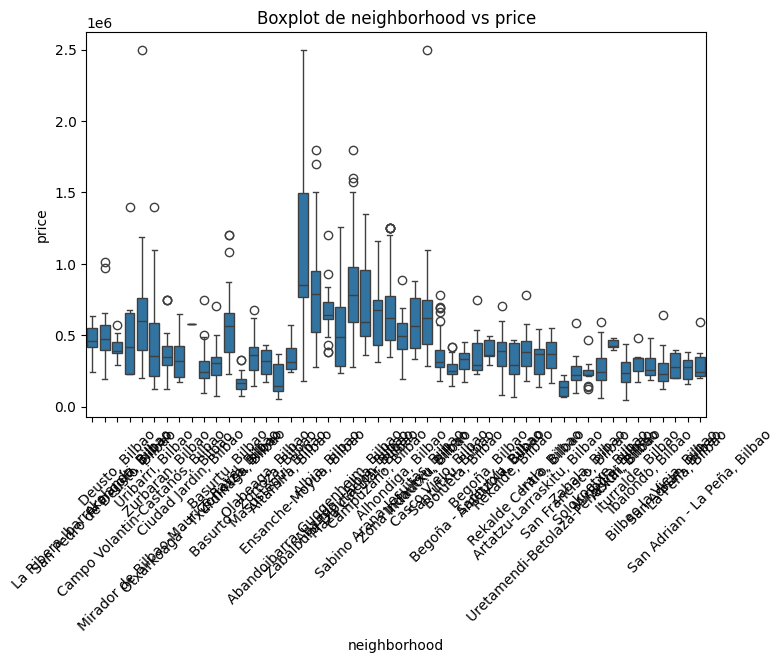

ANOVA neighborhood vs price: F=20.23, p=0.0000


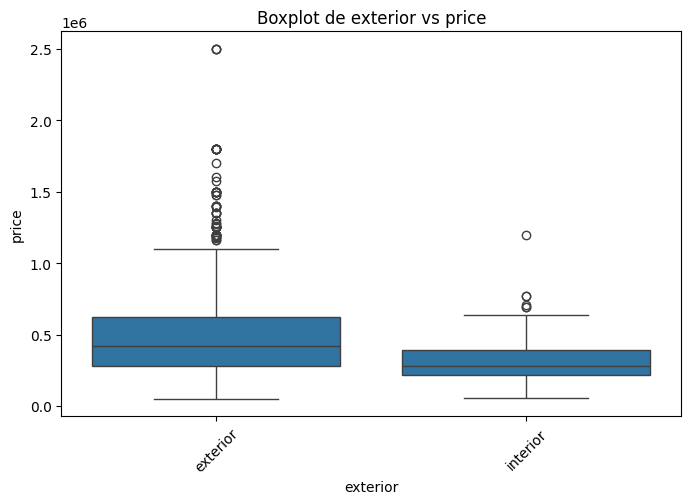

ANOVA exterior vs price: F=48.62, p=0.0000


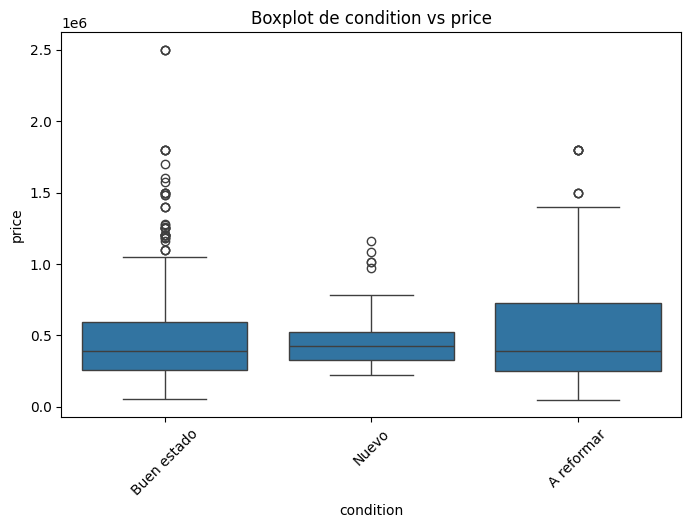

ANOVA condition vs price: F=3.40, p=0.0336


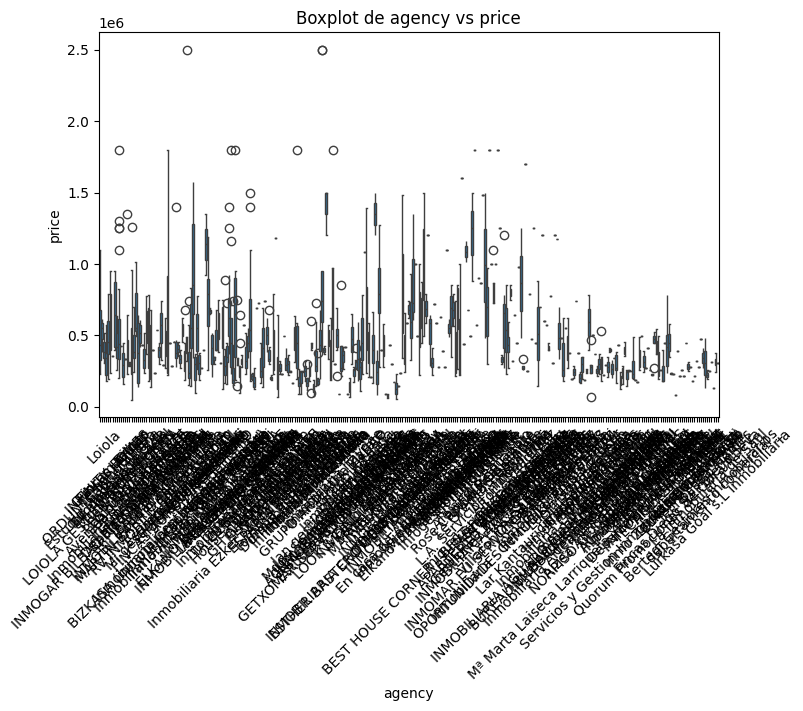

ANOVA agency vs price: F=3.05, p=0.0000


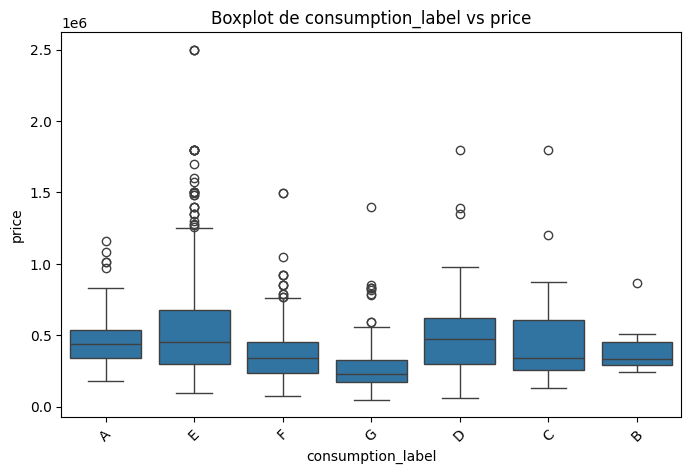

ANOVA consumption_label vs price: F=22.76, p=0.0000


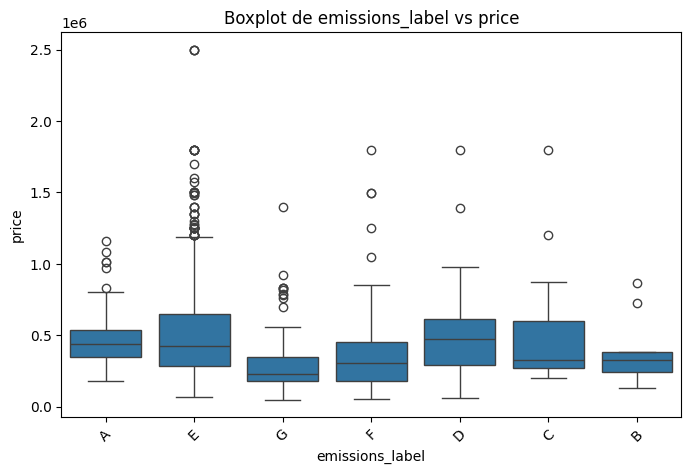

ANOVA emissions_label vs price: F=10.91, p=0.0000
DETECT NON LINEARITY------------------------------------


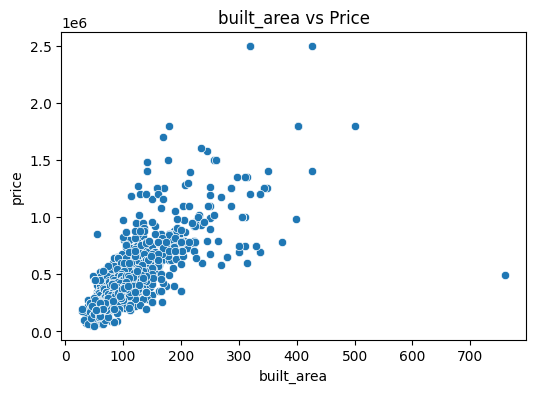

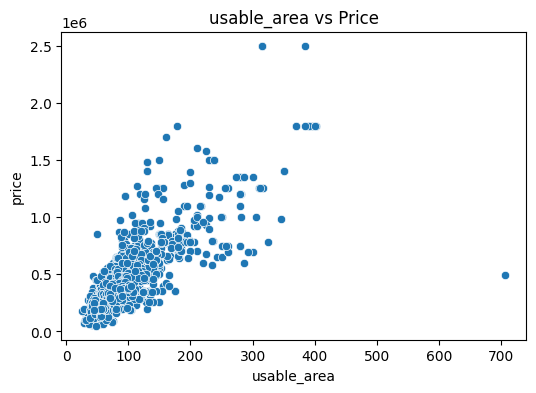

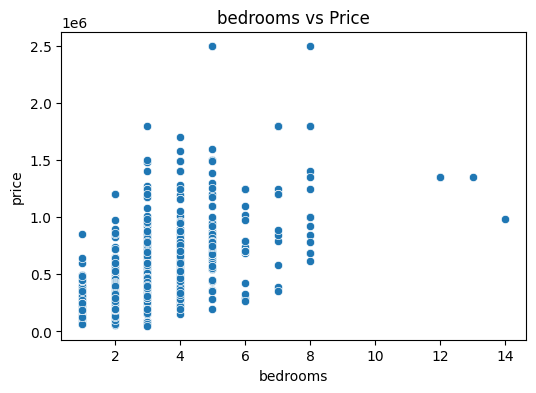

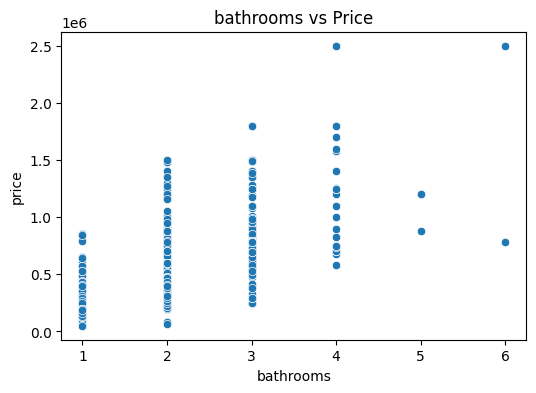

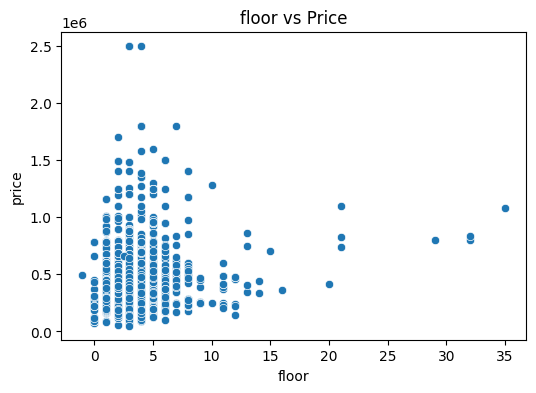

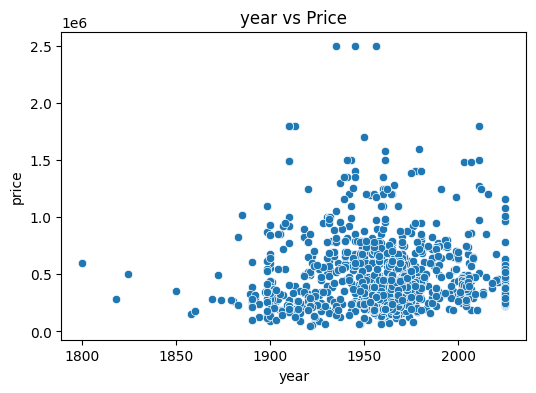

In [6]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Suponiendo que tu dataframe se llama dataCpy
# y la variable objetivo es 'price'

# -------------------------------
# 3.1 Univariado
# -------------------------------
print("UNIVARIATE------------------------------------")
# Estadísticas generales del target
print("Target - Estadísticas generales:")
print(dataCpy['price'].describe())
print("\nSkew:", dataCpy['price'].skew())
print("Kurtosis:", dataCpy['price'].kurtosis())

# Histograma del target
plt.figure(figsize=(8,5))
sns.histplot(dataCpy['price'], bins=50, kde=True)
plt.title("Distribución del Target (price)")
plt.show()

# Estadísticas y histogramas de features numéricas
numerical_features = dataCpy.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('price')  # excluimos el target

for col in numerical_features:
    print(f"\nFeature: {col}")
    print(dataCpy[col].describe())
    plt.figure(figsize=(6,4))
    sns.histplot(dataCpy[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

# -------------------------------
# 3.2 Bivariado
# -------------------------------
print("BIVARIATE------------------------------------")

# Correlación numérica entre features y target
corr = dataCpy[numerical_features + ['price']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre features numéricas y target")
plt.show()

# Boxplots / ANOVA para categóricas
categorical_features = dataCpy.select_dtypes(include='object').columns.tolist()
if 'description' in categorical_features:
    categorical_features.remove('description')  # no usar la descripción de momento

for col in categorical_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=col, y='price', data=dataCpy)
    plt.title(f"Boxplot de {col} vs price")
    plt.xticks(rotation=45)
    plt.show()

    # ANOVA (opcional)
    categories = dataCpy[col].dropna().unique()
    groups = [dataCpy[dataCpy[col]==cat]['price'] for cat in categories]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA {col} vs price: F={f_val:.2f}, p={p_val:.4f}")

# -------------------------------
# 3.3 Detectar no linealidades
# -------------------------------
print("DETECT NON LINEARITY------------------------------------")

# Scatterplots de X vs Y (numéricas)
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price', data=dataCpy)
    plt.title(f"{col} vs Price")
    plt.show()



As we can see in these results, the distribution of the target (price) is very skewed, which may be the reason of non linearity (or not clear linearity) with features like: floor or year.
So we will apply a logarithmic transformation to the target feature price. This should: 
- Improve futre heterodasdicity
- Improve current possible outliers 
- Improve linearity between features 

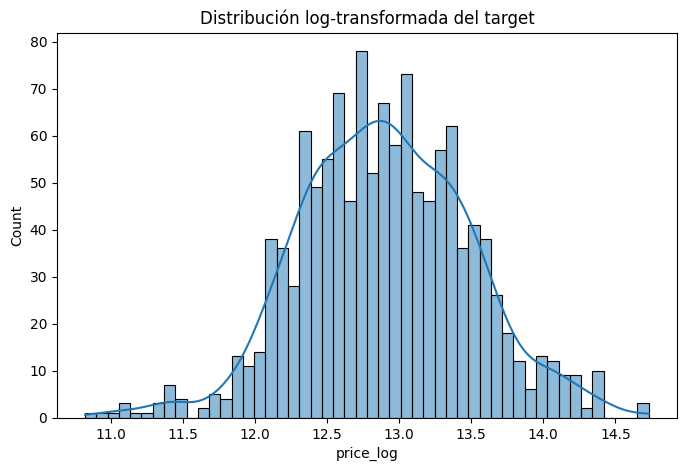


Skew: -0.0021085746449260837
Kurtosis: 0.29523924736662055
BIVARIATE------------------------------------


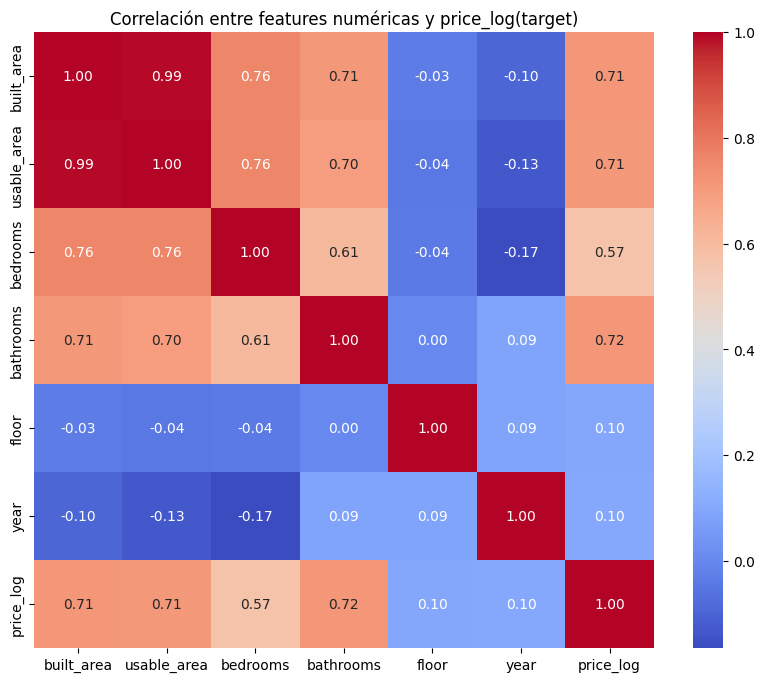

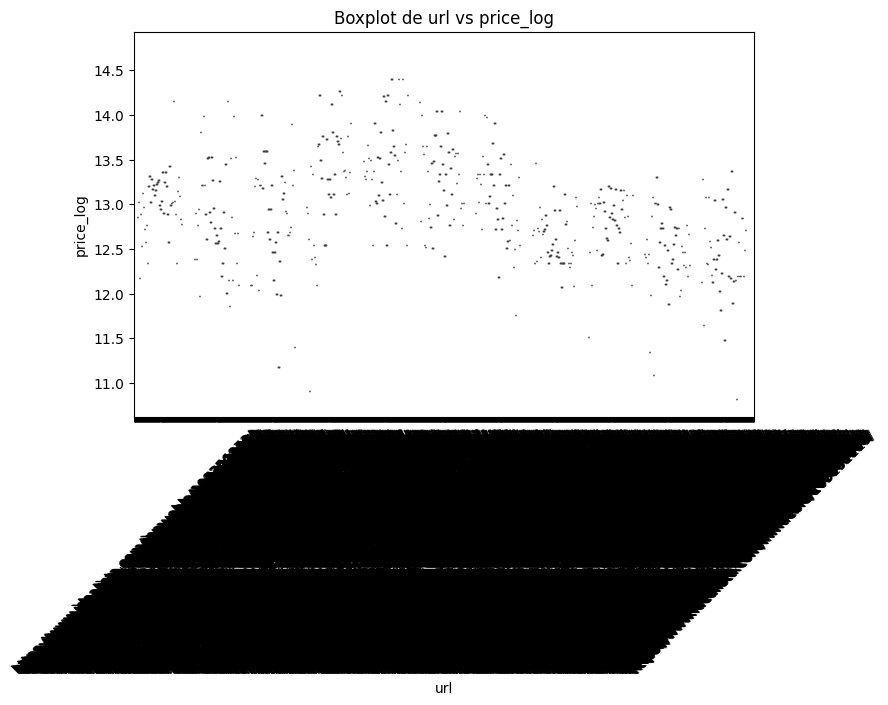

ANOVA url vs price_log: F=nan, p=nan


C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\david.r\AppData\Local\Temp\ipykernel_4196\3488007448.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_val, p_val = stats.f_oneway(*groups)


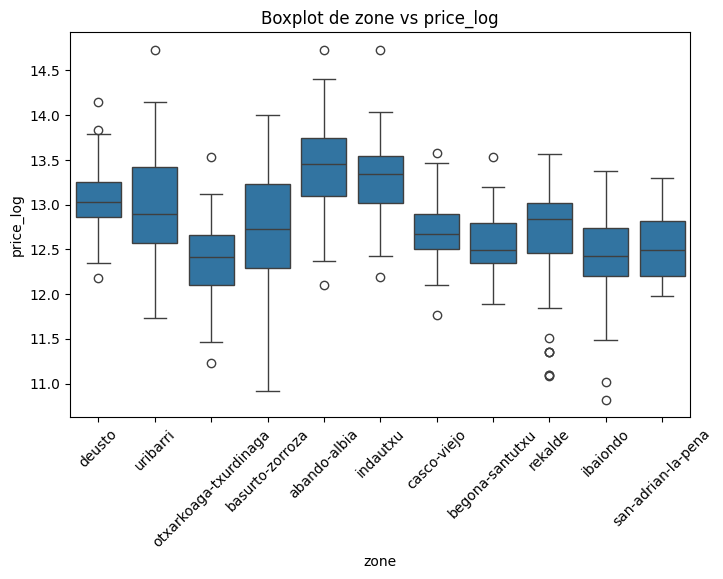

ANOVA zone vs price_log: F=69.90, p=0.0000


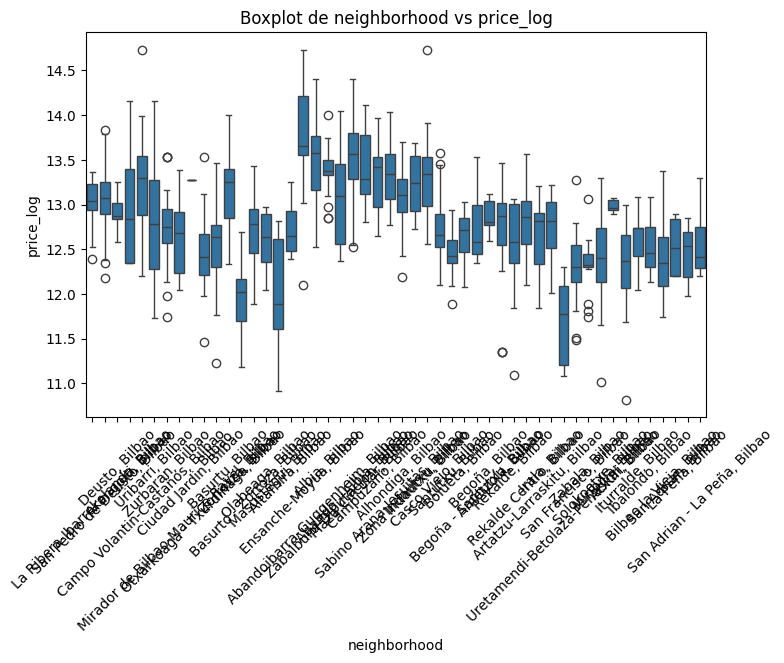

ANOVA neighborhood vs price_log: F=25.86, p=0.0000


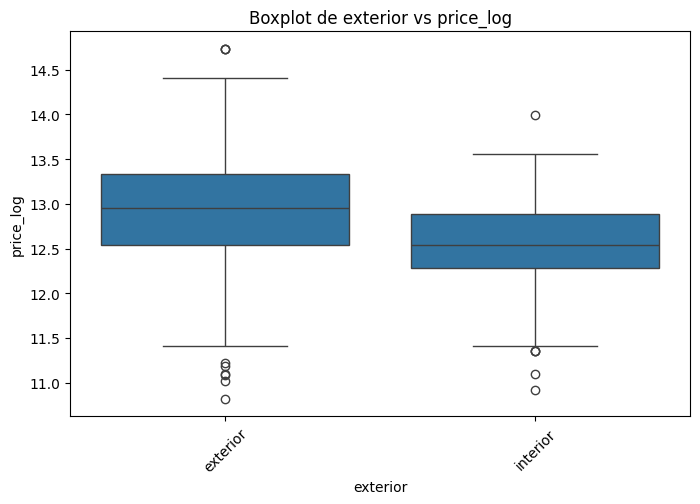

ANOVA exterior vs price_log: F=70.22, p=0.0000


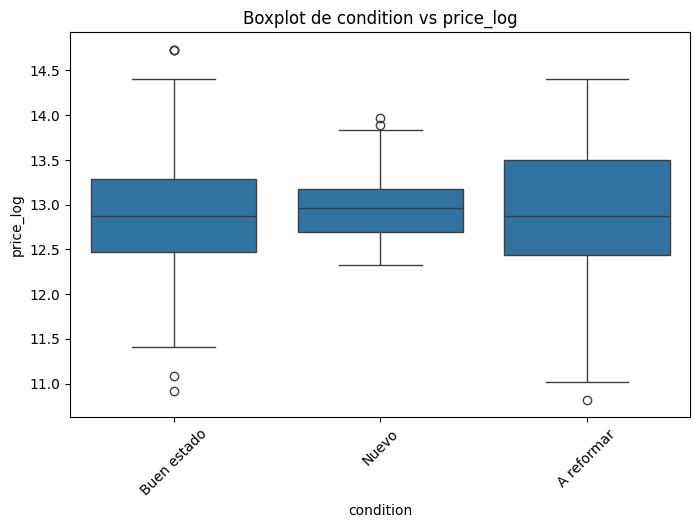

ANOVA condition vs price_log: F=0.92, p=0.3978


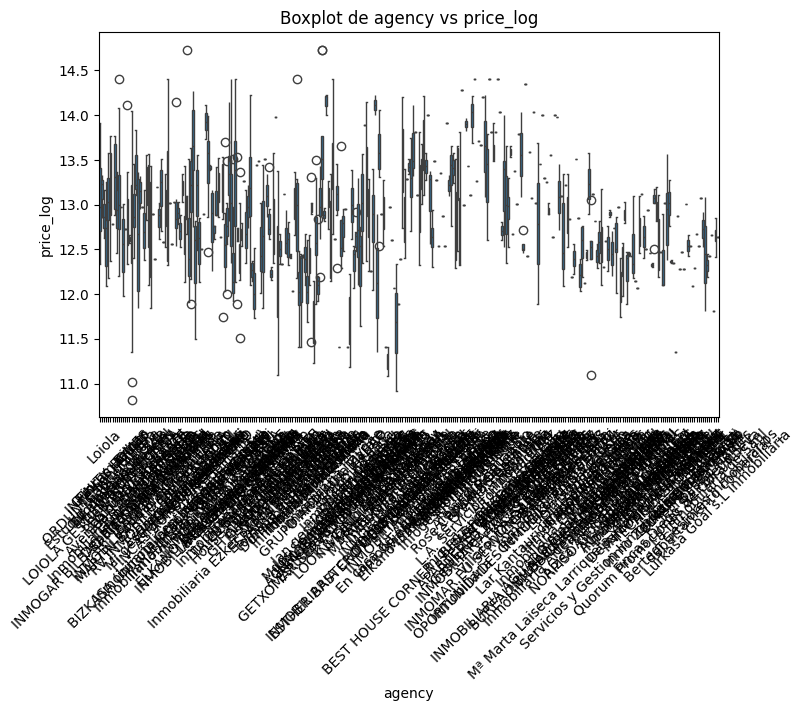

ANOVA agency vs price_log: F=3.24, p=0.0000


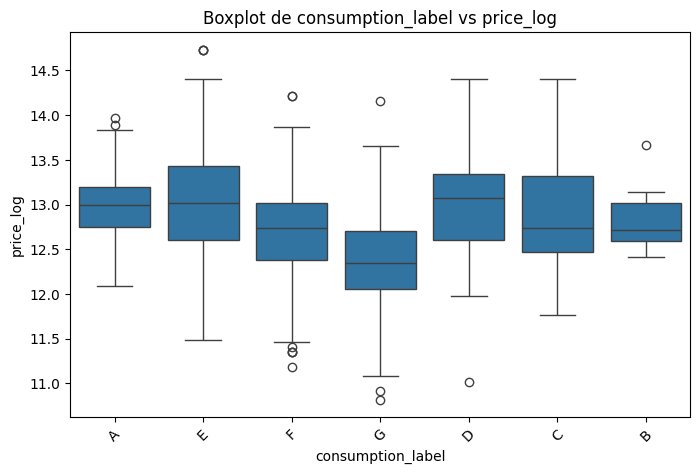

ANOVA consumption_label vs price_log: F=42.63, p=0.0000


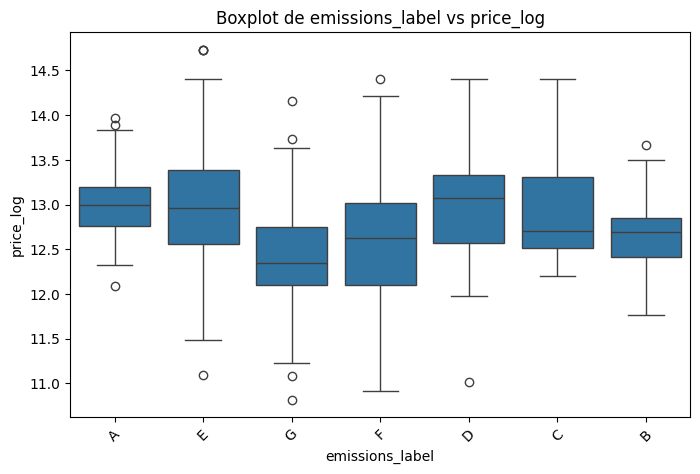

ANOVA emissions_label vs price_log: F=22.77, p=0.0000
DETECT NON LINEARITY------------------------------------


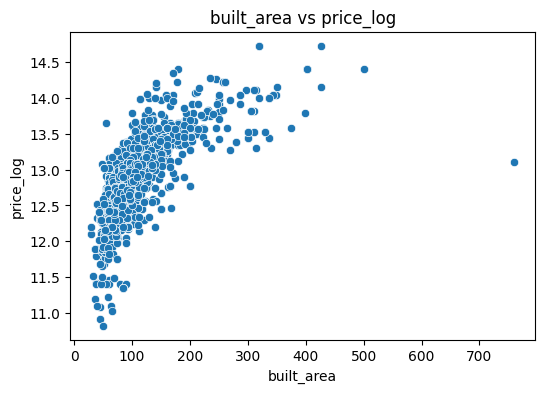

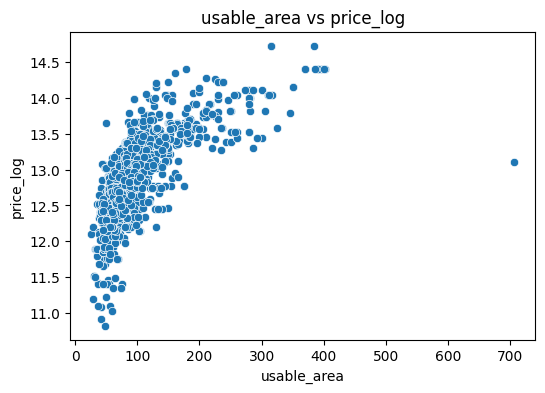

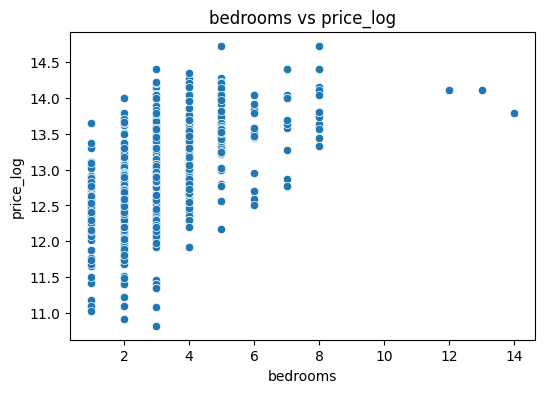

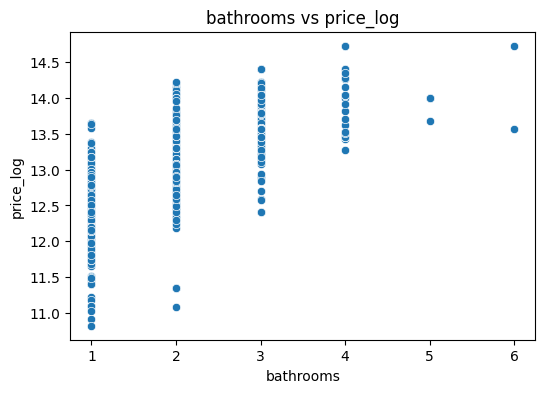

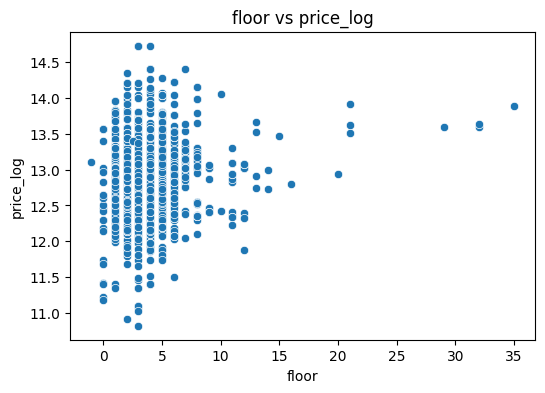

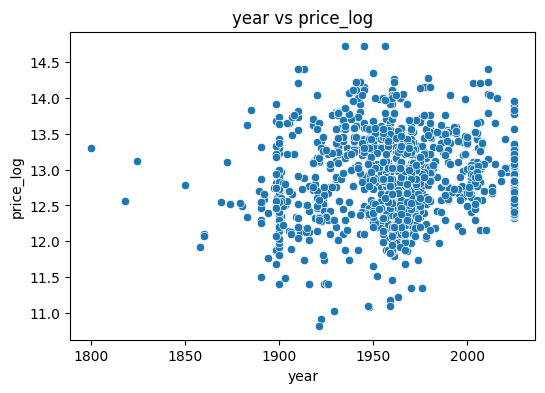

In [7]:

dataCpy['price_log'] = np.log1p(dataCpy['price'])

plt.figure(figsize=(8,5))
sns.histplot(dataCpy['price_log'], bins=50, kde=True)
plt.title("Distribución log-transformada del target")
plt.show()
print("\nSkew:", dataCpy['price_log'].skew())
print("Kurtosis:", dataCpy['price_log'].kurtosis())



# -------------------------------
# 3.2 Bivariate
# -------------------------------
print("BIVARIATE------------------------------------")

corr = dataCpy[numerical_features + ['price_log']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación entre features numéricas y price_log(target)")
plt.show()

# Boxplots / ANOVA para categóricas
categorical_features = dataCpy.select_dtypes(include='object').columns.tolist()
if 'description' in categorical_features:
    categorical_features.remove('description')  # no usar la descripción de momento

for col in categorical_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"Boxplot de {col} vs price_log")
    plt.xticks(rotation=45)
    plt.show()

    # ANOVA (opcional)
    categories = dataCpy[col].dropna().unique()
    groups = [dataCpy[dataCpy[col]==cat]['price_log'] for cat in categories]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"ANOVA {col} vs price_log: F={f_val:.2f}, p={p_val:.4f}")

print("DETECT NON LINEARITY------------------------------------")

# Scatterplots de X vs Y (numéricas)
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"{col} vs price_log")
    plt.show()



The results have improved: 
- less potential outliers: previously in the boxplots of zone vs price, there were potential outliers in uribarri, abando and indautxu. In year vs price around 1950 there were also 3 possible outliers.
- We gained a little bit of linearity in floor vs price relation. 
- There is still not linearity between year and price, this means that "year" is not directly proportionl with price.

However we lost a little bit of linearity (now has kind of logaritmic shape) in usable_area vs price and in built_area vs price; as well as in bedrooms and bathrooms so we will also transform usable_area and built_area to get that previous linearity. 

In [31]:
dataCpy.columns

Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'agency',
       'consumption_label', 'emissions_label', 'description', 'price_log',
       'log_built_area', 'log_usable_area', 'log_bedroom', 'log_bathroom'],
      dtype='object')

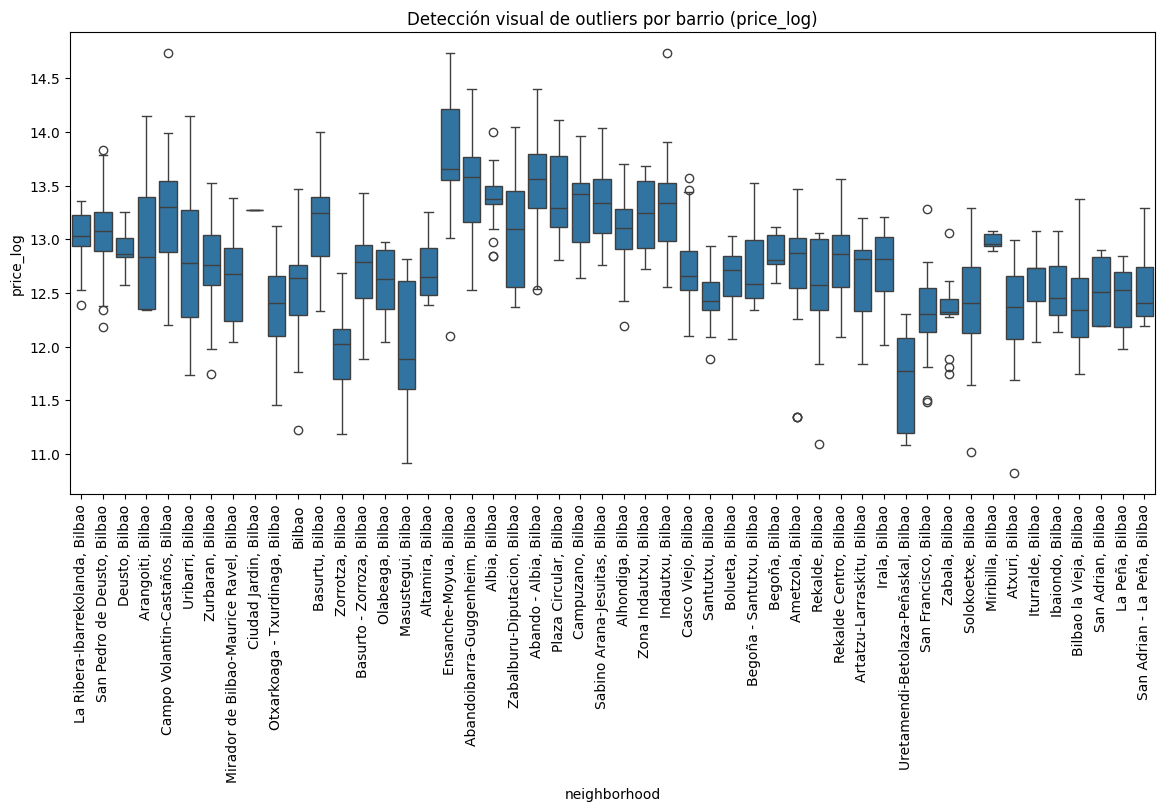

Outliers detectados: 31


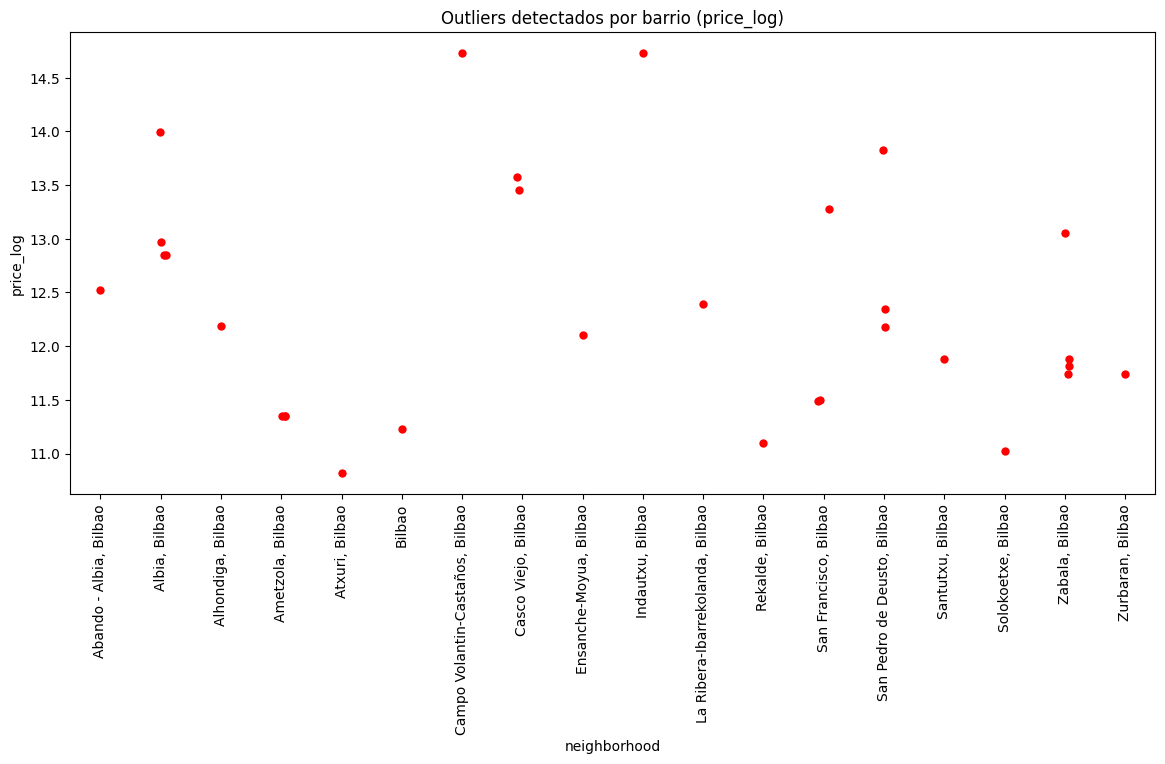

https://www.idealista.com/inmueble/107624252/  275001.00  Abando - Albia, Bilbao
https://www.idealista.com/inmueble/109360536/  430001.00  Albia, Bilbao
https://www.idealista.com/inmueble/107252250/  380001.00  Albia, Bilbao
https://www.idealista.com/inmueble/98413651/  380001.00  Albia, Bilbao
https://www.idealista.com/inmueble/106973182/  1200001.00  Albia, Bilbao
https://www.idealista.com/inmueble/108897414/  197001.00  Alhondiga, Bilbao
https://www.idealista.com/inmueble/107623208/  85000.00  Ametzola, Bilbao
https://www.idealista.com/inmueble/105848587/  85000.00  Ametzola, Bilbao
https://www.idealista.com/inmueble/35483234/  85000.00  Ametzola, Bilbao
https://www.idealista.com/inmueble/108863561/  50001.00  Atxuri, Bilbao
https://www.idealista.com/inmueble/107608811/  75001.00  Bilbao
https://www.idealista.com/inmueble/105222282/  2500001.00  Campo Volantin-Castaños, Bilbao
https://www.idealista.com/inmueble/100817168/  785001.00  Casco Viejo, Bilbao
https://www.idealista.com/inm

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="neighborhood", y="price_log")
plt.xticks(rotation=90)
plt.title("Detección visual de outliers por barrio (price_log)")
plt.show()

df = dataCpy.copy()

outliers_list = []

for nb, group in df.groupby("neighborhood"):
    Q1 = group["price_log"].quantile(0.25)
    Q3 = group["price_log"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group["price_log"] < lower_bound) | (group["price_log"] > upper_bound)]
    outliers_list.append(outliers)

outliers_df = pd.concat(outliers_list)
print("Outliers detectados:", outliers_df.shape[0])
outliers_df.head()

# Detectar outliers por barrio usando IQR
outliers_list = []

for nb, group in df.groupby("neighborhood"):
    Q1 = group["price_log"].quantile(0.25)
    Q3 = group["price_log"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group["price_log"] < lower_bound) | (group["price_log"] > upper_bound)]
    outliers_list.append(outliers)

outliers_df = pd.concat(outliers_list)

# Plot solo los outliers
plt.figure(figsize=(14, 6))
sns.stripplot(data=outliers_df, x="neighborhood", y="price_log", color='red', size=6, jitter=True)
plt.xticks(rotation=90)
plt.title("Outliers detectados por barrio (price_log)")
plt.show()


# Filas completas de dataCpy correspondientes a los outliers detectados
outliers_rows = dataCpy.loc[outliers_df.index]

# Mostrar las primeras filas
for idx, row in outliers_rows.iterrows():
    print(f"{row['url']}  {np.exp(row['price_log']):.2f}  {row['neighborhood']}")

    # Borrar los outliers de dataCpy
dataCpy_clean = dataCpy.drop(outliers_df.index).reset_index(drop=True)

print(f"Filas originales: {dataCpy.shape[0]}")
print(f"Filas después de eliminar outliers: {dataCpy_clean.shape[0]}")



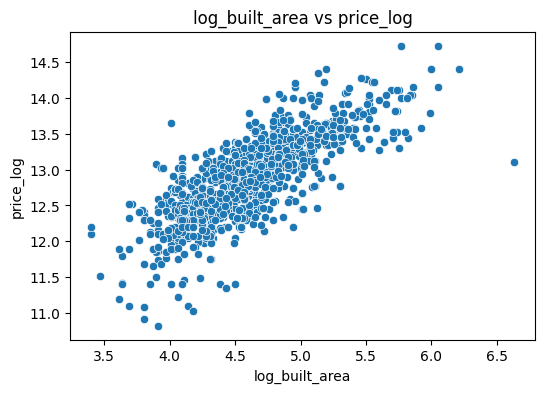

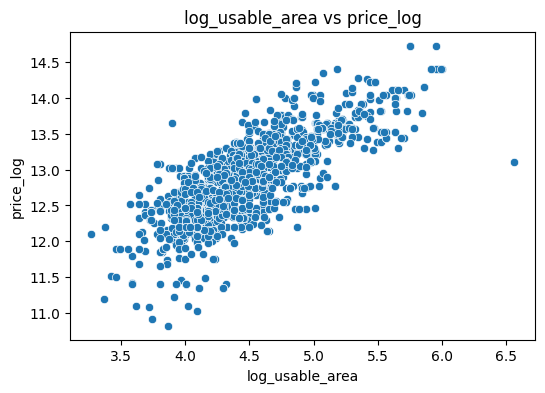

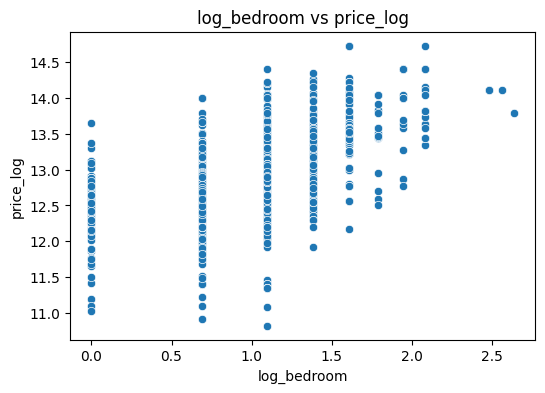

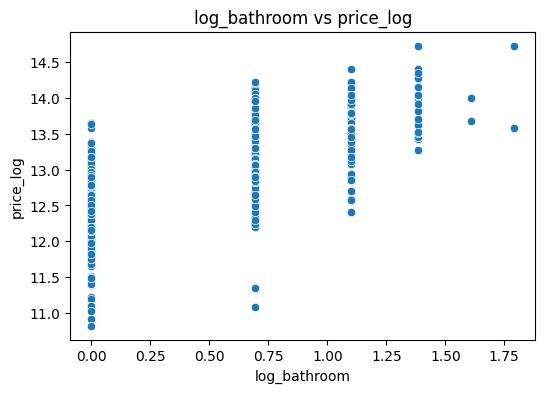

In [8]:
dataCpy["log_built_area"] = np.log(dataCpy["built_area"])
dataCpy["log_usable_area"] = np.log(dataCpy["usable_area"])
dataCpy["log_bedroom"] = np.log(dataCpy["bedrooms"])
dataCpy["log_bathroom"] = np.log(dataCpy["bathrooms"])



for col in ["log_built_area","log_usable_area","log_bedroom","log_bathroom"]:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price_log', data=dataCpy)
    plt.title(f"{col} vs price_log")
    plt.show()

#We have get that linearity again, PERFECT

The 3 potential outliers in bedroom vs price disappear with this trasnformation

We will check potential leverage in usable and built area vs price

Empty DataFrame
Columns: [url, price, zone, neighborhood, built_area, usable_area, bedrooms, bathrooms, floor, exterior, elevator, garage, storage_room, balcony, new, condition, year, agency, consumption_label, emissions_label, description, price_log, log_built_area, log_usable_area, log_bedroom, log_bathroom]
Index: []

[0 rows x 26 columns]


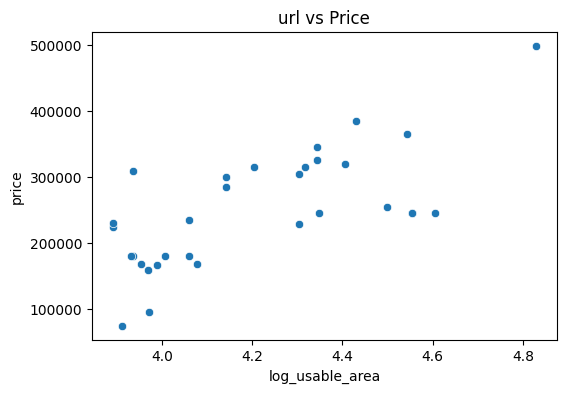

KeyError: '[226] not found in axis'

In [53]:
#We print the house
print(dataCpy.loc[dataCpy["usable_area"]>=700])
#As we can see in the plot house in otxarkoaga-txurdinaga, with 700m2 of usable area is cleary a leverage point, so we will delete it from our data_regresion
data=dataCpy.loc[dataCpy["zone"]=="otxarkoaga-txurdinaga"]
dataCpy

plt.figure(figsize=(6,4))
sns.scatterplot(x=dataCpy["log_usable_area"], y='price', data=data)
plt.title(f"{col} vs Price")
plt.show()

#we delete it
dataCpy = dataCpy.drop(index=226)
# Comprobar que se eliminó
#print(dataCpy.loc[226])  # gives error: correctly deleted


#Moreover the house with a price of more than 700k euros, is not from otxarkoaga-txurdinaga, but from Zurbaran (this may have been an error in scrapping), so we will change it to what it says in the web:
#Zone: uribarri
#neighbourhoof: Zurbaran, Bilbao
print(dataCpy.loc[(dataCpy["price"] >= 700000) & (dataCpy["zone"] == "otxarkoaga-txurdinaga")])

dataCpy.loc[211, "zone"] = "uribarri"
dataCpy.loc[211, "neighborhood"] = "Zurbaran, Bilbao"


print(dataCpy.loc[211])


# Simple Linear Regression
Now we will fit two linear regression models, 1 with and another without the transformations we made above, so that we can see how those transformations improved the model: 


In [54]:
#3.We will get the features which the model will be working with (initally)
print(f"All features: {dataCpy.columns}\n\n")


All features: Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'agency',
       'consumption_label', 'emissions_label', 'description', 'price_log',
       'log_built_area', 'log_usable_area', 'log_bedroom', 'log_bathroom'],
      dtype='object')




In [55]:

#target (with transformation)
target_price_transf = dataCpy.price_log

#target (with NO transformation)
target_price_no_transf = dataCpy.price


#For training the model will not take into account: Url, price, price_log (is the target), description and agency.
data_regresion = dataCpy.drop(["url","price","price_log", "description", "agency"], axis=1)

print(f"Initially selected features for model with transformations: {data_regresion.columns}")
#We deleted description feature, since the goal of the model is to predict or tell and announcment price with objective data of your house.
#We deleted the agency because of the same reason.


#1.We will check if there are missing values in the features we will be using(there should not be any, since we have previously done data cleaning)
print(f"Missing values:\n{data_regresion.isnull().sum()}") #0 missing values in target PERFECT



Initially selected features for model with transformations: Index(['zone', 'neighborhood', 'built_area', 'usable_area', 'bedrooms',
       'bathrooms', 'floor', 'exterior', 'elevator', 'garage', 'storage_room',
       'balcony', 'new', 'condition', 'year', 'consumption_label',
       'emissions_label', 'log_built_area', 'log_usable_area', 'log_bedroom',
       'log_bathroom'],
      dtype='object')
Missing values:
zone                 0
neighborhood         0
built_area           0
usable_area          0
bedrooms             0
bathrooms            0
floor                0
exterior             0
elevator             0
garage               0
storage_room         0
balcony              0
new                  0
condition            0
year                 0
consumption_label    0
emissions_label      0
log_built_area       0
log_usable_area      0
log_bedroom          0
log_bathroom         0
dtype: int64


In [56]:
# Convert to binary
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new', 'exterior']

binary_map = {
    True: 1, False: 0, 
    'True': 1, 'False': 0, 
    'Nuevo': 1, 'Buen estado': 0, 
    'exterior': 1, 'interior': 0
}

for col in binary_cols:
    data_regresion[col] = data_regresion[col].map(binary_map)

# Create Dummies
categorical_cols = ['zone', 'neighborhood', 'condition', 'consumption_label', 'emissions_label']
data_regresion = pd.get_dummies(data_regresion, columns=categorical_cols, drop_first=True)




print(data_regresion.shape)
#print(data_regresion.head())
num_filas_nan = data_regresion.isna().any(axis=1).sum()
print("Rows with NAN:", num_filas_nan) #0 rows with Nan (perfect)


(1228, 89)
Rows with NAN: 0


In [57]:
#we do not select the log transformed features for the model with no transformations
data_regresion_no_transformed = data_regresion.drop(["log_built_area","log_usable_area","log_bathroom","log_bedroom"], axis=1)

print(f"Initially selected features for model with no transformations: {data_regresion_no_transformed.columns}")

#we select the log transformed features for the model with  transformations
data_regresion_transformed = data_regresion.drop(["built_area","usable_area","bathrooms","bedrooms"], axis=1)

print(f"Initially selected features for model with transformations: {data_regresion_transformed.columns}")
#We deleted description feature, since the goal of the model is to predict or tell and announcment price with objective data of your house.
#We deleted the agency because of the same reason.

Initially selected features for model with no transformations: Index(['built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor',
       'exterior', 'elevator', 'garage', 'storage_room', 'balcony', 'new',
       'year', 'zone_basurto-zorroza', 'zone_begona-santutxu',
       'zone_casco-viejo', 'zone_deusto', 'zone_ibaiondo', 'zone_indautxu',
       'zone_otxarkoaga-txurdinaga', 'zone_rekalde', 'zone_san-adrian-la-pena',
       'zone_uribarri', 'neighborhood_Abandoibarra-Guggenheim, Bilbao',
       'neighborhood_Albia, Bilbao', 'neighborhood_Alhondiga, Bilbao',
       'neighborhood_Altamira, Bilbao', 'neighborhood_Ametzola, Bilbao',
       'neighborhood_Arangoiti, Bilbao',
       'neighborhood_Artatzu-Larraskitu, Bilbao',
       'neighborhood_Atxuri, Bilbao', 'neighborhood_Basurto - Zorroza, Bilbao',
       'neighborhood_Basurtu, Bilbao',
       'neighborhood_Begoña - Santutxu, Bilbao', 'neighborhood_Begoña, Bilbao',
       'neighborhood_Bilbao', 'neighborhood_Bilbao la Vieja, Bilbao

## Linear Regression without previous transformations

In [58]:

X = data_regresion_no_transformed
y = target_price_no_transf


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


model = LinearRegression()

#We apply cross validation (eventhough this is not helpful for selecting hyperparameters; since we do not have hyperparameters in simple linear regression, it will help us to detect overfitting or underfittin)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(model, X_train, y_train, cv=kf)


cv_mae = mean_absolute_error(y_train, y_pred)
cv_r2 = r2_score(y_train, y_pred)


print("CV MAE: %.2f €" % cv_mae)
print("CV R²: %.3f" % cv_r2)
relative_mae = np.mean(np.abs(y_train - y_pred) / y_train)
print("Relative MAE CV: %.2f%%\n\n" % (relative_mae*100))

model.fit(X_train, y_train)

#We finally evaluate the model with test
y_pred = model.predict(X_test)



mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Test MAE: %.2f €" % mae_test)
print("Test R²: %.3f" % r2_test)

# Relative MAE (this is the one we will really take into account)
relative_mae = np.mean(np.abs(y_test - y_pred) / y_test)
print("Relative MAE: %.2f%%" % (relative_mae*100))

CV MAE: 82786.35 €
CV R²: 0.834
Relative MAE CV: 20.99%


Test MAE: 95690.02 €
Test R²: 0.810
Relative MAE: 20.86%


### Underfitting/Overfitting evaluation: 

- there is NOT underfitting: R2 is both high in train and test and MAE are both more or less the same, a little high however. 
- there is NOT overfitting: the difference between R2 and MAE in train and test is not big enough.

Conclusion: no underfitting nor overfitting but the model is not good enough (20.39% of MAE is high)

## Linear Regression with previous transformations

In [59]:


X = data_regresion_transformed
y = target_price_transf


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


model = LinearRegression()

#We apply cross validation (eventhough this is not helpful for selecting hyperparameters; since we do not have hyperparameters in simple linear regression, it will help us to detect overfitting or underfittin)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv_log = cross_val_predict(model, X_train, y_train, cv=kf)

#Since in EDA we transformed the target price to logaritmic, we now transform it again to original units so that we can interpret the metrics
y_pred_cv = np.exp(y_pred_cv_log)
y_true_cv = np.exp(y_train)

cv_mae = mean_absolute_error(y_true_cv, y_pred_cv)
cv_r2 = r2_score(y_true_cv, y_pred_cv)

print("CV MAE: %.2f €" % cv_mae)
print("CV R²: %.3f" % cv_r2)
relative_mae = np.mean(np.abs(y_true_cv - y_pred_cv) / y_true_cv)
print("Relative MAE CV: %.2f%%\n\n" % (relative_mae*100))

model.fit(X_train, y_train)

#We finally evaluate the model with test
y_pred_log = model.predict(X_test)

#Again, since in EDA we transformed the target price to logaritmic, we now transform it again to original units so that we can interpret the metrics
y_pred = np.exp(y_pred_log)
y_test_euros = np.exp(y_test)

mae_test = mean_absolute_error(y_test_euros, y_pred)
r2_test = r2_score(y_test_euros, y_pred)

print("Test MAE: %.2f €" % mae_test)
print("Test R²: %.3f" % r2_test)

# Relative MAE (this is the one we will really take into account)
relative_mae = np.mean(np.abs(y_test_euros - y_pred) / y_test_euros)
print("Relative MAE: %.2f%%" % (relative_mae*100))


CV MAE: 73854.21 €
CV R²: 0.858
Relative MAE CV: 17.21%


Test MAE: 81173.84 €
Test R²: 0.848
Relative MAE: 16.42%


### Underfitting/Overfitting evaluation: 

- there is NOT underfitting: R2 is both high in train and test and MAE are both more or less the same, a little high however. 
- there is NOT overfitting: the difference between R2 and MAE in train and test is not big enough.

Conclusion: no underfitting nor overfitting and the model is better than the one without transformations, but it is still not good enough (16.42% of MAE is still high)

##### As we can see the log transformation improved the simple linear regression model, however we will now try with regularization methods and more complex models to try to improve even more the results

# Regularization methods

- These methods are good for controlling the overfitting, however we do not have problmatic overfitting in our simple linear regresisno with transformation, so they may not give much better results


### We first define the evaluation functions for optuna

In [60]:
import optuna
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X = data_regresion_transformed
y = target_price_transf  # log-transformado

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Evaluation functions for optuna (we want optuna to minimize the relative mae)
def objective_lasso(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    
    model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol, fit_intercept=fit_intercept)
    
    y_pred_log = cross_val_predict(model, X_train, y_train, cv=kf)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_train)

    
    relative_mae = np.mean(np.abs(y_true - y_pred)/y_true)
    return relative_mae

def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    solver = trial.suggest_categorical('solver', ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga'])
    
    model = Ridge(alpha=alpha, max_iter=max_iter, tol=tol, fit_intercept=fit_intercept, solver=solver)
    
    y_pred_log = cross_val_predict(model, X_train, y_train, cv=kf)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_train)
    relative_mae = np.mean(np.abs(y_true - y_pred)/y_true)
    return relative_mae

def objective_elasticnet(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    max_iter = trial.suggest_int('max_iter', 1000, 10000, step=1000)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    selection = trial.suggest_categorical('selection', ['cyclic','random'])
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol,
                       fit_intercept=fit_intercept, selection=selection)
    
    y_pred_log = cross_val_predict(model, X_train, y_train, cv=kf)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_train)
    relative_mae = np.mean(np.abs(y_true - y_pred)/y_true)
    return relative_mae



### Optuna for the hyperparameters

In [61]:

#We use "minimize" because we want optuna to minimze the relative mae
study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=50)

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=50)

study_en = optuna.create_study(direction='minimize')
study_en.optimize(objective_elasticnet, n_trials=50)



[I 2025-11-25 23:59:21,761] A new study created in memory with name: no-name-5676fc99-67db-4d8d-bbaf-29d95d2a3b30
C:\Users\david.r\AppData\Local\Temp\ipykernel_4196\3905174806.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)
C:\Users\david.r\AppData\Local\Temp\ipykernel_4196\3905174806.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

### From now on for evaluating the models we will be using this function

In [62]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # ---- TRAIN ----
    y_train_pred_log = model.predict(X_train)
    y_train_pred = np.exp(y_train_pred_log)
    y_train_true = np.exp(y_train)

    mae_train = mean_absolute_error(y_train_true, y_train_pred)
    r2_train = r2_score(y_train_true, y_train_pred)
    rel_mae_train = np.mean(np.abs(y_train_true - y_train_pred) / y_train_true) *100

    # ---- TEST ----
    y_test_pred_log = model.predict(X_test)
    y_test_pred = np.exp(y_test_pred_log)
    y_test_true = np.exp(y_test)

    mae_test = mean_absolute_error(y_test_true, y_test_pred)
    r2_test = r2_score(y_test_true, y_test_pred)
    rel_mae_test = np.mean(np.abs(y_test_true - y_test_pred) / y_test_true)*100

    return {
        "train": {
            "MAE": mae_train,
            "R2": r2_train,
            "Relative MAE": rel_mae_train
        },
        "test": {
            "MAE": mae_test,
            "R2": r2_test,
            "Relative MAE": rel_mae_test
        }
    }


### Evaluate the best models (the ones with the best hyperparameters selected by Optuna)


In [63]:
#** is for despackaging a dictionary

best_lasso = Lasso(**study_lasso.best_params)
best_lasso.fit(X_train, y_train)
best_ridge = Ridge(**study_ridge.best_params)
best_ridge.fit(X_train, y_train)
best_en = ElasticNet(**study_en.best_params)
best_en.fit(X_train, y_train)

metrics_lasso = evaluate_model(best_lasso, X_train, X_test, y_train, y_test)
metrics_ridge = evaluate_model(best_ridge, X_train, X_test, y_train, y_test)
metrics_en = evaluate_model(best_en, X_train, X_test, y_train, y_test)

# ---------- LASSO ----------
print("LASSO Train:")
print(f"R2 = {metrics_lasso['train']['R2']:.3f}")
print(f"MAE = {metrics_lasso['train']['MAE']:.2f} €")
print(f"Relative MAE = {metrics_lasso['train']['Relative MAE']:.2f}%\n")

print("LASSO Test:")
print(f"R2 = {metrics_lasso['test']['R2']:.3f}")
print(f"MAE = {metrics_lasso['test']['MAE']:.2f} €")
print(f"Relative MAE = {metrics_lasso['test']['Relative MAE']:.2f}%\n")


# ---------- RIDGE ----------
print("RIDGE Train:")
print(f"R2 = {metrics_ridge['train']['R2']:.3f}")
print(f"MAE = {metrics_ridge['train']['MAE']:.2f} €")
print(f"Relative MAE = {metrics_ridge['train']['Relative MAE']:.2f}%\n")

print("RIDGE Test:")
print(f"R2 = {metrics_ridge['test']['R2']:.3f}")
print(f"MAE = {metrics_ridge['test']['MAE']:.2f} €")
print(f"Relative MAE = {metrics_ridge['test']['Relative MAE']:.2f}%\n")


# ---------- ELASTIC NET ----------
print("ELASTIC NET Train:")
print(f"R2 = {metrics_en['train']['R2']:.3f}")
print(f"MAE = {metrics_en['train']['MAE']:.2f} €")
print(f"Relative MAE = {metrics_en['train']['Relative MAE']:.2f}%\n")

print("ELASTIC NET Test:")
print(f"R2 = {metrics_en['test']['R2']:.3f}")
print(f"MAE = {metrics_en['test']['MAE']:.2f} €")
print(f"Relative MAE = {metrics_en['test']['Relative MAE']:.2f}%\n")


LASSO Train:
R2 = 0.872
MAE = 68692.65 €
Relative MAE = 15.26%

LASSO Test:
R2 = 0.827
MAE = 82924.64 €
Relative MAE = 16.29%

RIDGE Train:
R2 = 0.879
MAE = 67731.31 €
Relative MAE = 15.38%

RIDGE Test:
R2 = 0.846
MAE = 81260.54 €
Relative MAE = 16.34%

ELASTIC NET Train:
R2 = 0.871
MAE = 68506.33 €
Relative MAE = 15.46%

ELASTIC NET Test:
R2 = 0.834
MAE = 83100.38 €
Relative MAE = 16.48%



### Evaluation of underfitting or overfitting

Overall in the 3 models...: 
- there is NOT underfitting: R2 are both high in train and test and MAE are both more or less the same and not to high. 
- there is NOT problematic overfitting: it is true that there is a difference between R2 but no so big to consider it as prolematic and MAE in train and test is nearly 0.


### Until NOW.....

The best model is achieved applying LASSO regularization, 
LASSO Test:
- R2 = 0.829
- MAE = 82704.19 €
- Relative MAE = 16.32%

Simple Linear regression with transformations
- R²: 0.848
- MAE: 81173.84 €
- Relative MAE: 16.42%

# More Complex Models

In [64]:
import re

X = data_regresion_transformed.copy()

# Reemplaza cualquier caracter que NO sea a-z, A-Z, 0-9 o _
X.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', col) for col in X.columns]


In [22]:
# ================================================
#   MODELOS CON HIPERPARÁMETROS 100% DEFAULT
# ================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# ===========================================================
# FUNCION DE ENTRENAMIENTO Y EVALUACION
# ===========================================================

def train_and_evaluate(model, name, X, y, cat_features=None):
    print(f"\n======================================")
    print(f"      {name}")
    print("======================================")

    # --- Escalado solo para modelos que lo necesitan ---
    if name in ["RANSAC","TheilSen","HuberRegressor","SVR"]:
        scaler = StandardScaler()
        X_scaled_np = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled_np, columns=X.columns, index=X.index)
        X_use = X_scaled
    else:
        X_use = X.copy()

    # --- Train/Test split ---
    X_train, X_test, y_train, y_test = train_test_split(X_use, y, test_size=0.2, random_state=42)

    # --- Fit ---
    if name == "CatBoost":
        # CatBoost necesita cat_features como índice de columnas
        model.fit(X_train, y_train, cat_features=cat_features)
    else:
        model.fit(X_train, y_train)

    # --- Evaluación ---
    results = evaluate_model(model, X_train, X_test, y_train, y_test)

    print("Train:")
    print(results["train"])
    print("Test:")
    print(results["test"])

    return results

# ===========================================================
# PREPARACION DE DATOS
# ===========================================================

# Escoge el dataset transformado para modelos lineales y boosting
X = data_regresion_transformed.copy()
y = target_price_transf

# Sanea nombres de columnas para LightGBM y XGBoost
X.columns = [col.replace(" ", "_")
                .replace("-", "_")
                .replace("+", "plus")
                .replace(".", "_")
                .replace("(", "_")
                .replace(")", "_")
             for col in X.columns]

# Para CatBoost: identificar columnas categóricas originales (sin dummies)
# Ejemplo: si 'zone', 'neighborhood', 'condition' son categóricas
cat_features = [X.columns.get_loc(col) for col in ['zone', 'neighborhood', 'condition', 'consumption_label', 'emissions_label'] if col in X.columns]

# ===========================================================
# 1) RANSAC
# ===========================================================
model_ransac = RANSACRegressor()
results_ransac = train_and_evaluate(model_ransac, "RANSAC", X, y)

# ===========================================================
# 2) TheilSen
# ===========================================================
model_theilsen = TheilSenRegressor()
results_theilsen = train_and_evaluate(model_theilsen, "TheilSen", X, y)

# ===========================================================
# 3) Huber Regressor
# ===========================================================
model_huber = HuberRegressor()
results_huber = train_and_evaluate(model_huber, "HuberRegressor", X, y)

# ===========================================================
# 4) SVR
# ===========================================================
model_svr = SVR()
results_svr = train_and_evaluate(model_svr, "SVR", X, y)

# ===========================================================
# 5) RandomForestRegressor
# ===========================================================
model_rf = RandomForestRegressor()
results_rf = train_and_evaluate(model_rf, "RandomForestRegressor", X, y)

# ===========================================================
# 6) XGBoost
# ===========================================================
model_xgb = xgb.XGBRegressor()
results_xgb = train_and_evaluate(model_xgb, "XGBoost", X, y)


# ===========================================================
# 8) CatBoostRegressor
# ===========================================================
model_cat = CatBoostRegressor(verbose=False)
results_cat = train_and_evaluate(model_cat, "CatBoost", X, y, cat_features=cat_features)




      RANSAC
Train:
{'MAE': 68009.00778817914, 'R2': 0.8744379613323868, 'Relative MAE': np.float64(16.368026880371755)}
Test:
{'MAE': 82000.63940677421, 'R2': 0.8290074781706531, 'Relative MAE': np.float64(16.37966397763625)}

      TheilSen
Train:
{'MAE': 268859.7868732529, 'R2': -0.33750706510298234, 'Relative MAE': np.float64(62.07926646381707)}
Test:
{'MAE': 292044.98755251477, 'R2': -0.2308197993213814, 'Relative MAE': np.float64(62.88604031707662)}

      HuberRegressor
Train:
{'MAE': 65315.67969721056, 'R2': 0.8813840858701363, 'Relative MAE': np.float64(15.398096980195497)}
Test:
{'MAE': 80496.95358638154, 'R2': 0.8344018412106613, 'Relative MAE': np.float64(16.20594222810866)}

      SVR


C:\Users\david.r\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train:
{'MAE': 49402.32902491785, 'R2': 0.9170987140110021, 'Relative MAE': np.float64(10.598308740713927)}
Test:
{'MAE': 86954.95392922114, 'R2': 0.7708510156774877, 'Relative MAE': np.float64(17.027908942161314)}

      RandomForestRegressor
Train:
{'MAE': 27624.210406755865, 'R2': 0.9710733786348527, 'Relative MAE': np.float64(6.0715344149604435)}
Test:
{'MAE': 87945.8245588827, 'R2': 0.7462709321904994, 'Relative MAE': np.float64(16.44479964914413)}

      XGBoost
Train:
{'MAE': 11885.954481447283, 'R2': 0.9954386448245303, 'Relative MAE': np.float64(2.4602723557393404)}
Test:
{'MAE': 80224.32018546748, 'R2': 0.8075920511855754, 'Relative MAE': np.float64(16.190193419812704)}

      CatBoost
Train:
{'MAE': 34195.80815807014, 'R2': 0.9663060454592445, 'Relative MAE': np.float64(7.2549097398146785)}
Test:
{'MAE': 81336.5764195677, 'R2': 0.790172290913551, 'Relative MAE': np.float64(15.75883660612864)}


Names of X were given erros to LGB, we correct them: 

In [23]:
import re

X = data_regresion_transformed.copy()

# Reemplaza cualquier carácter que NO sea a-z, A-Z, 0-9 o _
X.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', col) for col in X.columns]


In [24]:
# ===========================================================
# 7) LightGBM
# ===========================================================
model_lgb = lgb.LGBMRegressor()
results_lgb = train_and_evaluate(model_lgb, "LightGBM", X, y)


      LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 49
[LightGBM] [Info] Start training from score 12.890682
Train:
{'MAE': 35519.68704932165, 'R2': 0.9588468083106845, 'Relative MAE': np.float64(7.749481352461124)}
Test:
{'MAE': 87540.87538292242, 'R2': 0.757178920881719, 'Relative MAE': np.float64(17.051262415801737)}


The model with best results was Catboost: 
- Train: {'MAE': 33856.750083802915, 'R2': 0.9682897741114807, 'Relative MAE': np.float64(7.1315719948868805)}

- Test:{'MAE': 76261.65822870554, 'R2': 0.8032661334717063, 'Relative MAE': np.float64(15.809566463416372)}

However Relative MAE is still high and we can detect important overfitting, so we will use optuna to select the best hyperparameters for this model withe the objective of: 
- Reducing the overfitting
- Improving (reducing the Relative MAE)

In [71]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import numpy as np

# -------------------------------
# Datos
# -------------------------------
X = data_regresion_transformed.copy()
y = target_price_transf

# Identifica las columnas categóricas (si las hay)
categorical_cols = ['zone', 'neighborhood', 'condition', 'consumption_label', 'emissions_label']
cat_features = [X.columns.get_loc(c) for c in categorical_cols if c in X.columns]

# -------------------------------
# Función objetivo para Optuna
# -------------------------------
def objective(trial):
    # Hiperparámetros a optimizar
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'depth': trial.suggest_int('depth', 4, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.6, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'verbose': 0,
        'task_type': 'CPU'  # Cambia a 'GPU' si tienes GPU
    }


    # Split train/validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = CatBoostRegressor(**params)

    # Pool para CatBoost
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=100,
        use_best_model=True
    )

    # Predicción y cálculo Relative MAE en validación
    y_pred = model.predict(X_val)
    y_true = np.exp(y_val)
    y_pred_exp = np.exp(y_pred)

    rel_mae = np.mean(np.abs(y_true - y_pred_exp) / y_true) * 100
    return rel_mae


# -------------------------------
# Ejecutar Optuna
# -------------------------------
study = optuna.create_study(direction='minimize', study_name='CatBoost_Relative_MAE')
study.optimize(objective, n_trials=50, timeout=3600)  # Ajusta n_trials y timeout según recursos

# -------------------------------
# Resultados
# -------------------------------
print("Mejor Relative MAE:", study.best_value)
print("Mejores hiperparámetros:")
print(study.best_params)

# -------------------------------
# Entrenar modelo final con mejores parámetros
# -------------------------------
best_params = study.best_params
best_params['verbose'] = 0
model_final = CatBoostRegressor(**best_params)

# Entrenamos con todo el dataset y usamos early stopping con validación interna
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model_final.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=100,
    use_best_model=True
)

# Evaluación final
results_final = evaluate_model(model_final, X_train, X_test, y_train, y_test)
print("Resultados finales (CatBoost optimizado):")
print("Train:", results_final['train'])
print("Test:", results_final['test'])



[I 2025-11-26 00:08:39,039] A new study created in memory with name: CatBoost_Relative_MAE
[I 2025-11-26 00:08:44,632] Trial 0 finished with value: 15.895339796603281 and parameters: {'iterations': 3749, 'depth': 6, 'learning_rate': 0.039982999468733675, 'l2_leaf_reg': 21.147118325776812, 'bagging_temperature': 0.9618959946307037, 'random_strength': 7.859243874786035, 'border_count': 162, 'subsample': 0.9486864536401924}. Best is trial 0 with value: 15.895339796603281.
[I 2025-11-26 00:08:48,062] Trial 1 finished with value: 16.564616306493214 and parameters: {'iterations': 3192, 'depth': 4, 'learning_rate': 0.022358965141275798, 'l2_leaf_reg': 14.28518890123485, 'bagging_temperature': 1.2120445666467194, 'random_strength': 18.621163253858867, 'border_count': 130, 'subsample': 0.7949629948399095}. Best is trial 0 with value: 15.895339796603281.
[W 2025-11-26 00:08:50,294] Trial 2 failed with parameters: {'iterations': 3539, 'depth': 6, 'learning_rate': 0.015858786548349574, 'l2_leaf_re

KeyboardInterrupt: 

### The best results were: 
- Train: {'MAE': 28687.90548651894, 'R2': 0.9763744415760818, 'Relative MAE': np.float64(6.109109198120632)}
- Test: {'MAE': 77985.3029421027, 'R2': 0.8054084897862667, 'Relative MAE': np.float64(15.09525364088306)}

### Which is better than the model with LASSO regularization: 

Simple Linear regression with transformations
- R2 = 0.827
- MAE = 82924.64 €
- Relative MAE = 16.29%

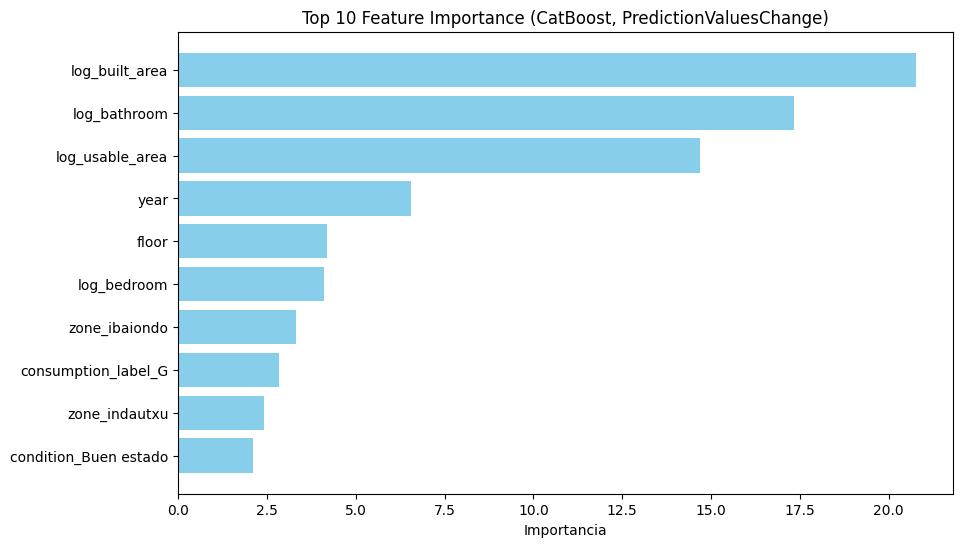

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener importancia de features
importances = model_final.get_feature_importance(type='PredictionValuesChange')
imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Tomar solo las 10 primeras
top10 = imp_df.head(10)

# Graficar
plt.figure(figsize=(10,6))
plt.barh(top10['feature'], top10['importance'], color='skyblue')
plt.gca().invert_yaxis()  # la más importante arriba
plt.title("Top 10 Feature Importance (CatBoost, PredictionValuesChange)")
plt.xlabel("Importancia")
plt.show()



### We will apply optuna again deleting less significant features and with different hyperparemters. Objectives:
- Reduce Overfitting 
- Improve (reduce) relative MAE

In [76]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# -------------------------------
# Datos
# -------------------------------
X = data_regresion_transformed.copy()
y = target_price_transf

# Columnas categóricas
categorical_cols = ['zone', 'neighborhood', 'condition', 'consumption_label', 'emissions_label']
cat_features = [X.columns.get_loc(c) for c in categorical_cols if c in X.columns]

# -------------------------------
# Función objetivo para Optuna
# -------------------------------
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1500, 5000),
        'depth': trial.suggest_int('depth', 4, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 10, 50),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.7, 1.5),
        'random_strength': trial.suggest_float('random_strength', 5, 20),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'verbose': 0,
        'task_type': 'CPU'
    }

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = CatBoostRegressor(**params)
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=150, use_best_model=True)

    y_pred = model.predict(X_val)
    y_true = np.exp(y_val)
    y_pred_exp = np.exp(y_pred)
    rel_mae = np.mean(np.abs(y_true - y_pred_exp) / y_true) * 100
    return rel_mae

# -------------------------------
# Ejecutar Optuna
# -------------------------------
study = optuna.create_study(direction='minimize', study_name='CatBoost_Relative_MAE')
study.optimize(objective, n_trials=150)

print("Mejor Relative MAE:", study.best_value)
print("Mejores hiperparámetros:")
print(study.best_params)

# -------------------------------
# Entrenar modelo final con mejores parámetros
# -------------------------------
best_params = study.best_params
best_params['verbose'] = 0
model_final = CatBoostRegressor(**best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model_final.fit(train_pool, eval_set=test_pool, early_stopping_rounds=150, use_best_model=True)

# ------------------


[I 2025-11-26 00:12:09,577] A new study created in memory with name: CatBoost_Relative_MAE
[I 2025-11-26 00:12:11,720] Trial 0 finished with value: 17.793940322763778 and parameters: {'iterations': 1510, 'depth': 6, 'learning_rate': 0.01164490137945918, 'l2_leaf_reg': 12.292571482750514, 'bagging_temperature': 1.1755979706539652, 'random_strength': 17.389505433434657, 'border_count': 112, 'subsample': 0.9218077615083062}. Best is trial 0 with value: 17.793940322763778.
[I 2025-11-26 00:12:15,730] Trial 1 finished with value: 16.479274341803222 and parameters: {'iterations': 3534, 'depth': 5, 'learning_rate': 0.018497008938502098, 'l2_leaf_reg': 17.873492445636288, 'bagging_temperature': 0.7534252754540267, 'random_strength': 18.832864106561722, 'border_count': 244, 'subsample': 0.8518104964341922}. Best is trial 1 with value: 16.479274341803222.
[I 2025-11-26 00:12:18,462] Trial 2 finished with value: 16.857362963204835 and parameters: {'iterations': 3411, 'depth': 4, 'learning_rate': 

Mejor Relative MAE: 14.870412503908142
Mejores hiperparámetros:
{'iterations': 4458, 'depth': 6, 'learning_rate': 0.03839571482741599, 'l2_leaf_reg': 10.727229392519817, 'bagging_temperature': 0.8451872251056328, 'random_strength': 19.0800450724098, 'border_count': 239, 'subsample': 0.7736820041887051}


In [77]:
# Evaluación final
results_final = evaluate_model(model_final, X_train, X_test, y_train, y_test)
print("Resultados finales (CatBoost optimizado):")
print("Train:", results_final['train'])
print("Test:", results_final['test'])


Resultados finales (CatBoost optimizado):
Train: {'MAE': 20811.3810327047, 'R2': 0.9879836798941708, 'Relative MAE': np.float64(4.404948817550537)}
Test: {'MAE': 76661.0988998852, 'R2': 0.8168530687652454, 'Relative MAE': np.float64(14.870412503908142)}


With the optimized hyperparameters, you run a 5-fold CV to:

verify stability

compare to the final test

obtain a more robust report

In [ ]:
best_params_cv = best_params.copy()
best_params_cv.pop("verbose", None)

from sklearn.model_selection import KFold
import numpy as np

# Deleted "verbose" from hyperparameters
best_params_cv = best_params.copy()
best_params_cv.pop("verbose", None)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rel_mae_scores = []

for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(**best_params_cv, verbose=0)

    model.fit(
        X_train_fold,
        y_train_fold,
        cat_features=cat_features
    )

    y_pred = np.exp(model.predict(X_val_fold))
    y_true = np.exp(y_val_fold)

    rel_mae = np.mean(np.abs(y_true - y_pred) / y_true) * 100
    rel_mae_scores.append(rel_mae)

print("\nCV Relative MAE (mean of the 10 folds):", np.mean(rel_mae_scores))
print("Std:", np.std(rel_mae_scores)) #how much the results differ within folds
print("Scores por fold:", rel_mae_scores)



CV Relative MAE (media 5 folds): 14.51826984637369
Std: 0.7902980849764997
Scores por fold: [np.float64(15.040083471947765), np.float64(14.51791935901382), np.float64(15.055293632036678), np.float64(12.988533030500607), np.float64(14.989519738369578)]


As we can see with Kfolds cross validation, depending of the train/test split, the results may improve for example in one case the model achieved 12.98 relative MAE which is near to the 10% we wanted to achieve.
We also can see that the std is 0.79, meaning that the model is stable and consistent across different partitions of the dataset.

### We will try to improve it, with other models:

In [26]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np

# -------------------------------
# Datos
# -------------------------------

X = data_regresion_transformed.copy()

# Reemplaza cualquier carácter que NO sea a-z, A-Z, 0-9 o _
X.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', col) for col in X.columns]

y = target_price_transf

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Función para calcular Relative MAE
def relative_mae(y_true, y_pred):
    return np.mean(np.abs(np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true)) * 100

# -------------------------------
# Función objetivo para Optuna
# -------------------------------
def objective_lgb(trial):
    params = {
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),  # default=31
        'max_depth': trial.suggest_int('max_depth', 3, 10),     # default=-1 (sin límite)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),  # default=0.1
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),  # default=100
        'subsample_for_bin': 200000,  # valor por defecto
        'objective': 'regression',
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),  # default=0.0
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 5.0),  # default=0.001
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),  # default=20
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # default=1.0
        'subsample_freq': 1,  # default=0
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # default=1.0
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),  # default=0.0
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),  # default=0.0
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )
    y_pred = model.predict(X_val)
    return relative_mae(y_val, y_pred)

# -------------------------------
# Ejecutar Optuna
# -------------------------------
study_lgb = optuna.create_study(direction='minimize', study_name='LGBM_Relative_MAE')
study_lgb.optimize(objective_lgb, n_trials=50)  # Ajusta n_trials según recursos

# Resultados
print("Mejor Relative MAE LGBM:", study_lgb.best_value)
print("Mejores hiperparámetros LGBM:")
print(study_lgb.best_params)



[I 2025-11-25 23:43:20,625] A new study created in memory with name: LGBM_Relative_MAE
[I 2025-11-25 23:43:20,753] Trial 0 finished with value: 19.34366139759455 and parameters: {'num_leaves': 21, 'max_depth': 7, 'learning_rate': 0.03935737378631112, 'n_estimators': 159, 'min_split_gain': 0.28587621518347955, 'min_child_weight': 4.01505247936571, 'min_child_samples': 13, 'subsample': 0.9844299671201886, 'colsample_bytree': 0.7009839811476473, 'reg_alpha': 2.0002078651302875, 'reg_lambda': 1.0350505876843257}. Best is trial 0 with value: 19.34366139759455.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 63
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:21,008] Trial 1 finished with value: 22.736472256333556 and parameters: {'num_leaves': 42, 'max_depth': 4, 'learning_rate': 0.16676749819399062, 'n_estimators': 1469, 'min_split_gain': 0.2235717757725132, 'min_child_weight': 0.722186073514792, 'min_child_samples': 43, 'subsample': 0.5011043067908643, 'colsample_bytree': 0.9627944887641059, 'reg_alpha': 4.860822476389194, 'reg_lambda': 2.0106756609805654}. Best is trial 0 with value: 19.34366139759455.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-25 23:43:21,390] Trial 2 finished with value: 19.79424272087118 and parameters: {'num_leaves': 37, 'max_depth': 8, 'learning_rate': 0.07110115499767787, 'n_estimators': 1967, 'min_split_gain': 0.05646308070558015, 'min_child_weight': 3.5957902666876933, 'min_child_samples': 38, 'subsample': 0.9599627243700539, 'colsample_bytree': 0.9794273934388102, 'reg_alpha': 0.2446364021658537, 'reg_lambda': 1.7903261876734344}. Best is trial 0 with value: 19.34366139759455.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-25 23:43:21,588] Trial 3 finished with value: 22.637736894814317 and parameters: {'num_leaves': 29, 'max_depth': 9, 'learning_rate': 0.012466456547555111, 'n_estimators': 574, 'min_split_gain': 0.3362665741591932, 'min_child_weight': 0.6124126740743109, 'min_child_samples': 31, 'subsample': 0.5503138257004202, 'colsample_bytree': 0.9873580531253341, 'reg_alpha': 4.385714418398761, 'reg_lambda': 0.3528697906203626}. Best is trial 0 with value: 19.34366139759455.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-25 23:43:22,015] Trial 4 finished with value: 18.895862934956675 and parameters: {'num_leaves': 49, 'max_depth': 8, 'learning_rate': 0.03754591278644965, 'n_estimators': 1370, 'min_split_gain': 0.011756458801752967, 'min_child_weight': 4.037737646953126, 'min_child_samples': 29, 'subsample': 0.8553833429932588, 'colsample_bytree': 0.9477478009039917, 'reg_alpha': 1.0748950423035804, 'reg_lambda': 4.7013823073860745}. Best is trial 4 with value: 18.895862934956675.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-11-25 23:43:22,320] Trial 5 finished with value: 21.367785238954546 and parameters: {'num_leaves': 26, 'max_depth': 8, 'learning_rate': 0.04081702554909328, 'n_estimators': 1465, 'min_split_gain': 0.03951194457552187, 'min_child_weight': 3.4167897340748303, 'min_child_samples': 46, 'subsample': 0.9570615490434866, 'colsample_bytree': 0.7418322300521818, 'reg_alpha': 1.200129239146872, 'reg_lambda': 3.9176951579541672}. Best is trial 4 with value: 18.895862934956675.
[I 2025-11-25 23:43:22,416] Trial 6 finished with value: 20.779401876340636 and parameters: {'num_leaves': 24, 'max_depth': 10, 'learning_rate': 0.07655024346564841, 'n_estimators': 314, 'min_split_gain': 0.3245795327163815, 'min_child_weight': 2.5826362029285628, 'min_child_samples': 20, 'subsample': 0.5583277776183642, 'colsample_bytree': 0.526440281708203, 'reg_alpha': 0.9848832728816476, 'reg_lambda': 0.3099468955942908}. Best is trial 4 with value: 18.895862934956675.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[I 2025-11-25 23:43:22,752] Trial 7 finished with value: 19.090202746856924 and parameters: {'num_leaves': 39, 'max_depth': 4, 'learning_rate': 0.024953421597911238, 'n_estimators': 1450, 'min_split_gain': 0.12927599186487526, 'min_child_weight': 4.062275116679627, 'min_child_samples': 18, 'subsample': 0.9616649658133567, 'colsample_bytree': 0.703501432682932, 'reg_alpha': 1.8821635598912367, 'reg_lambda': 3.89640423150467}. Best is trial 4 with value: 18.895862934956675.
[I 2025-11-25 23:43:22,845] Trial 8 finished with value: 20.23112413210574 and parameters: {'num_leaves': 27, 'max_depth': 4, 'learning_rate': 0.12227887378715314, 'n_estimators': 362, 'min_split_gain': 0.4437481476478352, 'min_child_weight': 1.2043153200087242, 'min_child_samples': 11, 'subsample': 0.7556255301751293, 'colsample_bytree': 0.5548788648608923, 'reg_alpha': 2.559160058128433, 'reg_lambda': 3.388964851174646}. Best is trial 4 with value: 18.895862934956675.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-25 23:43:23,103] Trial 9 finished with value: 21.93758042557588 and parameters: {'num_leaves': 38, 'max_depth': 9, 'learning_rate': 0.03227922135254451, 'n_estimators': 1362, 'min_split_gain': 0.38524220425563627, 'min_child_weight': 1.6796710192876128, 'min_child_samples': 23, 'subsample': 0.6728744402609581, 'colsample_bytree': 0.5817748716916515, 'reg_alpha': 4.313800991546514, 'reg_lambda': 3.4455540990207636}. Best is trial 4 with value: 18.895862934956675.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 41
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-11-25 23:43:23,469] Trial 10 finished with value: 21.010031372570655 and parameters: {'num_leaves': 58, 'max_depth': 6, 'learning_rate': 0.015715006767554215, 'n_estimators': 883, 'min_split_gain': 0.18082717535553472, 'min_child_weight': 4.641802357590875, 'min_child_samples': 31, 'subsample': 0.8325826156799677, 'colsample_bytree': 0.8678167365961414, 'reg_alpha': 3.0349746817010077, 'reg_lambda': 4.830355436877408}. Best is trial 4 with value: 18.895862934956675.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:23,908] Trial 11 finished with value: 19.529173264674206 and parameters: {'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.0235905371340471, 'n_estimators': 1851, 'min_split_gain': 0.11670788179448716, 'min_child_weight': 4.5221792349320165, 'min_child_samples': 23, 'subsample': 0.8579031084636417, 'colsample_bytree': 0.8288164414823571, 'reg_alpha': 1.6535942498702798, 'reg_lambda': 4.990802978798578}. Best is trial 4 with value: 18.895862934956675.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-25 23:43:24,491] Trial 12 finished with value: 16.633037308030662 and parameters: {'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.021157488144682615, 'n_estimators': 1098, 'min_split_gain': 0.005466033697470493, 'min_child_weight': 2.9169716561091636, 'min_child_samples': 18, 'subsample': 0.8643539121629353, 'colsample_bytree': 0.6572399856305622, 'reg_alpha': 0.05398806149570223, 'reg_lambda': 4.13892521763471}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-25 23:43:25,026] Trial 13 finished with value: 18.800787308006683 and parameters: {'num_leaves': 48, 'max_depth': 6, 'learning_rate': 0.018176965180027427, 'n_estimators': 1026, 'min_split_gain': 0.02427984042134875, 'min_child_weight': 2.7249483396183423, 'min_child_samples': 28, 'subsample': 0.8543791796301221, 'colsample_bytree': 0.6321899023826515, 'reg_alpha': 0.05573638707118453, 'reg_lambda': 4.422464158295549}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 43
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:25,389] Trial 14 finished with value: 19.4275366909639 and parameters: {'num_leaves': 50, 'max_depth': 6, 'learning_rate': 0.017729158361734228, 'n_estimators': 932, 'min_split_gain': 0.09795877483335372, 'min_child_weight': 2.480784330765521, 'min_child_samples': 27, 'subsample': 0.7725962114488183, 'colsample_bytree': 0.6333146339251273, 'reg_alpha': 0.038303536029066165, 'reg_lambda': 2.8739048239280427}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2025-11-25 23:43:25,751] Trial 15 finished with value: 21.411943880551203 and parameters: {'num_leaves': 59, 'max_depth': 5, 'learning_rate': 0.010329928912040962, 'n_estimators': 721, 'min_split_gain': 0.004006193722436165, 'min_child_weight': 2.5760433465997665, 'min_child_samples': 37, 'subsample': 0.6821791634169769, 'colsample_bytree': 0.6425856215386935, 'reg_alpha': 0.5059415077839776, 'reg_lambda': 4.176705692225166}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-25 23:43:26,128] Trial 16 finished with value: 20.21450648662886 and parameters: {'num_leaves': 45, 'max_depth': 5, 'learning_rate': 0.01781601988439272, 'n_estimators': 1093, 'min_split_gain': 0.1964574384373495, 'min_child_weight': 1.9048333980858771, 'min_child_samples': 15, 'subsample': 0.8901906748634892, 'colsample_bytree': 0.6252449172027786, 'reg_alpha': 3.2798758879021923, 'reg_lambda': 2.7527145986682156}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-11-25 23:43:26,397] Trial 17 finished with value: 19.823723346724144 and parameters: {'num_leaves': 55, 'max_depth': 7, 'learning_rate': 0.05820937762534986, 'n_estimators': 1160, 'min_split_gain': 0.07562490917498611, 'min_child_weight': 3.07556677803616, 'min_child_samples': 36, 'subsample': 0.8102683349326902, 'colsample_bytree': 0.8015908711769829, 'reg_alpha': 0.5418020046416431, 'reg_lambda': 4.36806279842841}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-11-25 23:43:26,902] Trial 18 finished with value: 19.243508213964617 and parameters: {'num_leaves': 33, 'max_depth': 5, 'learning_rate': 0.025422740823870135, 'n_estimators': 1752, 'min_split_gain': 0.14654744850322554, 'min_child_weight': 0.06984763282945305, 'min_child_samples': 25, 'subsample': 0.8984735733775889, 'colsample_bytree': 0.6855064830334522, 'reg_alpha': 0.024844047954260873, 'reg_lambda': 3.2138511904515745}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 52
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-11-25 23:43:27,493] Trial 19 finished with value: 20.039393676952404 and parameters: {'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.01314234600295867, 'n_estimators': 671, 'min_split_gain': 0.4718990719971112, 'min_child_weight': 1.9873345896976118, 'min_child_samples': 18, 'subsample': 0.6953413267372051, 'colsample_bytree': 0.5033080623142415, 'reg_alpha': 0.7914266979717723, 'reg_lambda': 2.1108197912856963}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-25 23:43:28,139] Trial 20 finished with value: 21.977238831903755 and parameters: {'num_leaves': 54, 'max_depth': 7, 'learning_rate': 0.020349516405388495, 'n_estimators': 1213, 'min_split_gain': 0.2619603843589476, 'min_child_weight': 3.046801843391238, 'min_child_samples': 50, 'subsample': 0.9085537128625842, 'colsample_bytree': 0.584093779944264, 'reg_alpha': 1.3490041098494718, 'reg_lambda': 3.693292114174193}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-25 23:43:29,432] Trial 21 finished with value: 18.460602306375836 and parameters: {'num_leaves': 50, 'max_depth': 8, 'learning_rate': 0.032115416674665546, 'n_estimators': 905, 'min_split_gain': 0.004625904276802539, 'min_child_weight': 3.814894657528305, 'min_child_samples': 28, 'subsample': 0.8028245942379436, 'colsample_bytree': 0.8779704280749259, 'reg_alpha': 0.5187930363742816, 'reg_lambda': 4.549579181357612}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 40
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:30,600] Trial 22 finished with value: 18.92731716688047 and parameters: {'num_leaves': 46, 'max_depth': 7, 'learning_rate': 0.029634491391209085, 'n_estimators': 918, 'min_split_gain': 0.004065944397307238, 'min_child_weight': 2.990310058518046, 'min_child_samples': 33, 'subsample': 0.802177820964309, 'colsample_bytree': 0.895104303637174, 'reg_alpha': 0.5332736640218543, 'reg_lambda': 4.409698528594386}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-25 23:43:31,078] Trial 23 finished with value: 17.85893794758758 and parameters: {'num_leaves': 53, 'max_depth': 9, 'learning_rate': 0.053656821449482306, 'n_estimators': 798, 'min_split_gain': 0.06518387376245224, 'min_child_weight': 3.373781366717459, 'min_child_samples': 21, 'subsample': 0.7267395436447229, 'colsample_bytree': 0.7814854029796124, 'reg_alpha': 0.030761649733792137, 'reg_lambda': 4.421527480334558}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 49
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:31,566] Trial 24 finished with value: 18.44222930911929 and parameters: {'num_leaves': 54, 'max_depth': 10, 'learning_rate': 0.052424900841853576, 'n_estimators': 771, 'min_split_gain': 0.06863831941919603, 'min_child_weight': 3.658733143779473, 'min_child_samples': 21, 'subsample': 0.7101145427670686, 'colsample_bytree': 0.780169417023781, 'reg_alpha': 0.6666693186821823, 'reg_lambda': 4.018423681949214}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-11-25 23:43:31,948] Trial 25 finished with value: 19.814368600945276 and parameters: {'num_leaves': 54, 'max_depth': 10, 'learning_rate': 0.05805311864308805, 'n_estimators': 491, 'min_split_gain': 0.07628923556682204, 'min_child_weight': 3.4126035968624087, 'min_child_samples': 20, 'subsample': 0.6446055288233005, 'colsample_bytree': 0.7907024669395347, 'reg_alpha': 1.5208018367205252, 'reg_lambda': 4.007214845725613}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-11-25 23:43:32,308] Trial 26 finished with value: 19.081615865256595 and parameters: {'num_leaves': 56, 'max_depth': 9, 'learning_rate': 0.09458879929103729, 'n_estimators': 738, 'min_split_gain': 0.1583073065301163, 'min_child_weight': 4.390194835634344, 'min_child_samples': 15, 'subsample': 0.7230693827729687, 'colsample_bytree': 0.7532062293667999, 'reg_alpha': 2.2461091216593982, 'reg_lambda': 3.0663886295426304}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-11-25 23:43:32,737] Trial 27 finished with value: 17.557246030746303 and parameters: {'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.05149644415268887, 'n_estimators': 805, 'min_split_gain': 0.09381548455973193, 'min_child_weight': 4.996142743141037, 'min_child_samples': 10, 'subsample': 0.6278553784516174, 'colsample_bytree': 0.7587583039277904, 'reg_alpha': 0.7514495167215016, 'reg_lambda': 2.5303216978597876}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2025-11-25 23:43:33,103] Trial 28 finished with value: 17.641028105432362 and parameters: {'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.11283936111050885, 'n_estimators': 543, 'min_split_gain': 0.09009140200721578, 'min_child_weight': 4.712365661966531, 'min_child_samples': 11, 'subsample': 0.6423906380320495, 'colsample_bytree': 0.6735041681156189, 'reg_alpha': 0.9325215727022377, 'reg_lambda': 1.3590780565845557}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-11-25 23:43:33,323] Trial 29 finished with value: 19.213743545235044 and parameters: {'num_leaves': 59, 'max_depth': 10, 'learning_rate': 0.15832340853196872, 'n_estimators': 257, 'min_split_gain': 0.11683683028720246, 'min_child_weight': 4.935851942508954, 'min_child_samples': 10, 'subsample': 0.5949827697158191, 'colsample_bytree': 0.6918033838338246, 'reg_alpha': 1.9690334866143961, 'reg_lambda': 1.1920435600557833}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[I 2025-11-25 23:43:33,451] Trial 30 finished with value: 18.65715299752819 and parameters: {'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.12259832249849592, 'n_estimators': 155, 'min_split_gain': 0.19927900164746767, 'min_child_weight': 4.77504312017058, 'min_child_samples': 13, 'subsample': 0.6409220605680291, 'colsample_bytree': 0.7121952615329193, 'reg_alpha': 0.9055042173115785, 'reg_lambda': 1.119990183604296}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2025-11-25 23:43:33,929] Trial 31 finished with value: 17.419062749689804 and parameters: {'num_leaves': 52, 'max_depth': 9, 'learning_rate': 0.04695034726815898, 'n_estimators': 513, 'min_split_gain': 0.08875028774568336, 'min_child_weight': 4.301623108340664, 'min_child_samples': 14, 'subsample': 0.6191939204356536, 'colsample_bytree': 0.7423407478070353, 'reg_alpha': 0.35013553486527704, 'reg_lambda': 0.7327125205427731}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-11-25 23:43:34,323] Trial 32 finished with value: 18.674348820793913 and parameters: {'num_leaves': 57, 'max_depth': 10, 'learning_rate': 0.08086817214461058, 'n_estimators': 480, 'min_split_gain': 0.09373925128880348, 'min_child_weight': 4.315294180403487, 'min_child_samples': 13, 'subsample': 0.6006945137010172, 'colsample_bytree': 0.6602213821141081, 'reg_alpha': 1.2538396340905154, 'reg_lambda': 0.8506630085431008}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-11-25 23:43:34,677] Trial 33 finished with value: 18.817829450120435 and parameters: {'num_leaves': 52, 'max_depth': 8, 'learning_rate': 0.046192452945975813, 'n_estimators': 576, 'min_split_gain': 0.23938998471127293, 'min_child_weight': 4.899302630844699, 'min_child_samples': 16, 'subsample': 0.628501826436977, 'colsample_bytree': 0.7355344169123554, 'reg_alpha': 0.3446450442848784, 'reg_lambda': 1.6351581100694337}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[I 2025-11-25 23:43:35,008] Trial 34 finished with value: 17.345723257039168 and parameters: {'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.1952494199682987, 'n_estimators': 400, 'min_split_gain': 0.04408430325628085, 'min_child_weight': 4.1525039923042515, 'min_child_samples': 10, 'subsample': 0.5193319408529753, 'colsample_bytree': 0.6589504367945188, 'reg_alpha': 0.8772223678143806, 'reg_lambda': 0.0312282085521578}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-11-25 23:43:35,467] Trial 35 finished with value: 17.35178498580889 and parameters: {'num_leaves': 42, 'max_depth': 8, 'learning_rate': 0.17984375740698683, 'n_estimators': 418, 'min_split_gain': 0.04610357204542595, 'min_child_weight': 4.278205287095789, 'min_child_samples': 10, 'subsample': 0.5209594019800177, 'colsample_bytree': 0.5945305434104, 'reg_alpha': 0.3133604654209834, 'reg_lambda': 0.06550872104830321}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:35,873] Trial 36 finished with value: 17.33532955612142 and parameters: {'num_leaves': 43, 'max_depth': 8, 'learning_rate': 0.18020696568092195, 'n_estimators': 397, 'min_split_gain': 0.05197003506402597, 'min_child_weight': 4.181100895844981, 'min_child_samples': 14, 'subsample': 0.5090993718173571, 'colsample_bytree': 0.6015857912457715, 'reg_alpha': 0.28304750799437495, 'reg_lambda': 0.5943587943377611}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:36,139] Trial 37 finished with value: 18.617104477492678 and parameters: {'num_leaves': 34, 'max_depth': 8, 'learning_rate': 0.1961766363832974, 'n_estimators': 126, 'min_split_gain': 0.03832989682604552, 'min_child_weight': 4.103151340612279, 'min_child_samples': 18, 'subsample': 0.5033091074031452, 'colsample_bytree': 0.5988179062976086, 'reg_alpha': 0.26210146095688325, 'reg_lambda': 0.143730374785963}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 52
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:36,398] Trial 38 finished with value: 18.08784033237925 and parameters: {'num_leaves': 41, 'max_depth': 8, 'learning_rate': 0.1526314367969812, 'n_estimators': 379, 'min_split_gain': 0.05030760921993502, 'min_child_weight': 4.071840701773601, 'min_child_samples': 12, 'subsample': 0.5372695222451287, 'colsample_bytree': 0.5591440601854754, 'reg_alpha': 1.0632193624031143, 'reg_lambda': 0.6064520302570994}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 53
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-11-25 23:43:36,732] Trial 39 finished with value: 21.206638472053225 and parameters: {'num_leaves': 36, 'max_depth': 7, 'learning_rate': 0.18869617954487375, 'n_estimators': 314, 'min_split_gain': 0.03939536368886962, 'min_child_weight': 3.73709203065812, 'min_child_samples': 17, 'subsample': 0.5026953638682528, 'colsample_bytree': 0.6104496628033963, 'reg_alpha': 4.931513995540296, 'reg_lambda': 0.04850929596153364}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-11-25 23:43:37,081] Trial 40 finished with value: 21.673383657264097 and parameters: {'num_leaves': 20, 'max_depth': 7, 'learning_rate': 0.14136947815899176, 'n_estimators': 231, 'min_split_gain': 0.3003885228266218, 'min_child_weight': 2.19614075691375, 'min_child_samples': 13, 'subsample': 0.5661144571056004, 'colsample_bytree': 0.5594475139949132, 'reg_alpha': 3.8329482872404643, 'reg_lambda': 0.5485969543292084}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-25 23:43:37,266] Trial 41 finished with value: 18.322520496892917 and parameters: {'num_leaves': 42, 'max_depth': 9, 'learning_rate': 0.17752757605793523, 'n_estimators': 424, 'min_split_gain': 0.03873069069783314, 'min_child_weight': 4.374880204100509, 'min_child_samples': 14, 'subsample': 0.5356965798387946, 'colsample_bytree': 0.6607983197302755, 'reg_alpha': 0.35032041237379213, 'reg_lambda': 0.7299943251562361}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 72
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-11-25 23:43:37,592] Trial 42 finished with value: 17.13506948515839 and parameters: {'num_leaves': 43, 'max_depth': 8, 'learning_rate': 0.09841675165320272, 'n_estimators': 631, 'min_split_gain': 0.03231138994390873, 'min_child_weight': 4.2437530151713405, 'min_child_samples': 10, 'subsample': 0.5673601599292246, 'colsample_bytree': 0.7282491380031574, 'reg_alpha': 0.2431692611540366, 'reg_lambda': 0.3954269225975875}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:37,917] Trial 43 finished with value: 17.303537191017153 and parameters: {'num_leaves': 43, 'max_depth': 8, 'learning_rate': 0.09464925657259605, 'n_estimators': 623, 'min_split_gain': 0.029261046995470694, 'min_child_weight': 3.8922388153469214, 'min_child_samples': 10, 'subsample': 0.5680456840394457, 'colsample_bytree': 0.7231915260022045, 'reg_alpha': 0.21781300074635424, 'reg_lambda': 0.21163931165213812}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 32
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-11-25 23:43:38,664] Trial 44 finished with value: 20.876609723653498 and parameters: {'num_leaves': 44, 'max_depth': 8, 'learning_rate': 0.10455717432131023, 'n_estimators': 619, 'min_split_gain': 0.023229782441271447, 'min_child_weight': 3.8817954676646003, 'min_child_samples': 42, 'subsample': 0.5762182373932029, 'colsample_bytree': 0.7193627819201911, 'reg_alpha': 0.7619471533360371, 'reg_lambda': 0.37818783020535074}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-25 23:43:39,454] Trial 45 finished with value: 17.088168816897493 and parameters: {'num_leaves': 39, 'max_depth': 7, 'learning_rate': 0.08820815330847093, 'n_estimators': 1267, 'min_split_gain': 0.02330222663416761, 'min_child_weight': 3.531400586666466, 'min_child_samples': 12, 'subsample': 0.5872317730350622, 'colsample_bytree': 0.6494802856265586, 'reg_alpha': 0.15080826644389234, 'reg_lambda': 0.329907286581657}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 56
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-11-25 23:43:40,602] Trial 46 finished with value: 16.887179982778118 and parameters: {'num_leaves': 39, 'max_depth': 7, 'learning_rate': 0.0691976008201457, 'n_estimators': 1602, 'min_split_gain': 0.020033534493092094, 'min_child_weight': 3.358584705324577, 'min_child_samples': 16, 'subsample': 0.5840172122961304, 'colsample_bytree': 0.6989744256993561, 'reg_alpha': 0.16179120961628943, 'reg_lambda': 0.35837016652844067}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 982, number of used features: 53
[LightGBM] [Info] Start training from score 12.890682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-11-25 23:43:41,043] Trial 47 finished with value: 20.935831509197325 and parameters: {'num_leaves': 39, 'max_depth': 7, 'learning_rate': 0.06727079739088342, 'n_estimators': 1595, 'min_split_gain': 0.3647179295072749, 'min_child_weight': 3.26939962631955, 'min_child_samples': 17, 'subsample': 0.5909184116415493, 'colsample_bytree': 0.7200501171148974, 'reg_alpha': 2.747197316148423, 'reg_lambda': 0.3897177521596451}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-25 23:43:41,935] Trial 48 finished with value: 16.92524544229937 and parameters: {'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.0876300959864523, 'n_estimators': 1259, 'min_split_gain': 0.0013210646589994351, 'min_child_weight': 2.8410428173661297, 'min_child_samples': 12, 'subsample': 0.6670252658394962, 'colsample_bytree': 0.8293079952780896, 'reg_alpha': 0.1626736530668753, 'reg_lambda': 0.9908643398668783}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-25 23:43:42,550] Trial 49 finished with value: 18.11805469995577 and parameters: {'num_leaves': 47, 'max_depth': 6, 'learning_rate': 0.07014086238014737, 'n_estimators': 1307, 'min_split_gain': 0.017562087689592276, 'min_child_weight': 2.7698978690332616, 'min_child_samples': 16, 'subsample': 0.6586973586061207, 'colsample_bytree': 0.8366848756996842, 'reg_alpha': 1.7529141387740574, 'reg_lambda': 2.0344558714031593}. Best is trial 12 with value: 16.633037308030662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, RANSACRegressor
from sklearn.preprocessing import StandardScaler

# Escalado para modelos que lo necesitan
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# -------------------------------
# 2d) RANSAC
# -------------------------------
def objective_ransac(trial):
    params = {
        'min_samples': trial.suggest_float('min_samples', 0.5, 1.0),
        'residual_threshold': trial.suggest_float('residual_threshold', 0.01, 0.5),
        'max_trials': trial.suggest_int('max_trials', 50, 200)
    }
    model = RANSACRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return relative_mae(y_val, y_pred)

study_ransac = optuna.create_study(direction='minimize')
study_ransac.optimize(objective_ransac, n_trials=30)
print("Mejores params RANSAC:", study_ransac.best_params)
print("Mejor Relative MAE RANSAC:", study_ransac.best_value)


[I 2025-11-25 18:50:11,031] A new study created in memory with name: no-name-8b33e1d1-5e85-4411-bca6-e0e7a563e649
[I 2025-11-25 18:50:12,301] Trial 0 finished with value: 15.805335908270651 and parameters: {'min_samples': 0.7607334800533563, 'residual_threshold': 0.35715595786008697, 'max_trials': 114}. Best is trial 0 with value: 15.805335908270651.
[I 2025-11-25 18:50:13,323] Trial 1 finished with value: 16.14061863330981 and parameters: {'min_samples': 0.8085335903729396, 'residual_threshold': 0.2760042582553125, 'max_trials': 99}. Best is trial 0 with value: 15.805335908270651.
[I 2025-11-25 18:50:14,024] Trial 2 finished with value: 16.3609743866777 and parameters: {'min_samples': 0.5768410414614633, 'residual_threshold': 0.3174637478761418, 'max_trials': 74}. Best is trial 0 with value: 15.805335908270651.
[I 2025-11-25 18:50:15,526] Trial 3 finished with value: 16.12348156113967 and parameters: {'min_samples': 0.7946851157939012, 'residual_threshold': 0.1266886180320102, 'max_tr

Mejores params RANSAC: {'min_samples': 0.6701598723347724, 'residual_threshold': 0.37461478403226883, 'max_trials': 198}
Mejor Relative MAE RANSAC: 15.80511829221824
